In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve

from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations
from statsmodels.stats.proportion import proportion_confint

In [2]:
data = pd.read_csv(
    'accepted_2007_to_2018Q4.csv',
    parse_dates=['issue_d'], infer_datetime_format=True,low_memory=False)
data = data[(data.issue_d >= '2018-01-01 00:00:00') & (data.issue_d < '2019-01-01 00:00:00')]
data = data.reset_index(drop=True)

data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,130954621,NaN,5000.0,5000.0,5000.0,36 months,20.39,186.82,D,D4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,130964697,NaN,15000.0,15000.0,15000.0,36 months,9.92,483.45,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,130955326,NaN,11200.0,11200.0,11200.0,60 months,30.79,367.82,G,G1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,130504052,NaN,25000.0,25000.0,25000.0,60 months,21.85,688.35,D,D5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,130956066,NaN,3000.0,3000.0,3000.0,36 months,7.34,93.10,A,A4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#data.to_csv("lending_club_2018.csv", sep=',')

In [4]:
# data=data[:20000]
# data.info()

In [5]:
browse_notes = pd.read_excel('LCDataDictionary.xlsx',
                             sheet_name=1)
browse_notes.head()

,BrowseNotesFile,Description
0,acceptD,The date which the borrower accepted the offer
1,accNowDelinq,The number of accounts on which the borrower i...
2,accOpenPast24Mths,Number of trades opened in past 24 months.
3,addrState,The state provided by the borrower in the loan...
4,all_util,Balance to credit limit on all trades


In [6]:
browse_feat = browse_notes['BrowseNotesFile'].dropna().values
browse_feat = [re.sub('(?<![0-9_])(?=[A-Z0-9])', '_', x).lower().strip() for x in browse_feat]

In [7]:
import numpy as np
data_feat = data.columns.values
np.setdiff1d(browse_feat, data_feat)

array(['accept_d', 'credit_pull_d', 'effective_int_rate', 'exp_d',
       'exp_default_rate', 'ils_exp_d', 'is_inc_v', 'list_d', 'msa',
       'mths_since_most_recent_inq', 'mths_since_oldest_il_open',
       'mths_since_recent_loan_delinq', 'review_status',
       'review_status_d', 'service_fee_rate', 'verified_status_joint'],
      dtype='<U35')

In [8]:
np.setdiff1d(data_feat, browse_feat)

array(['collection_recovery_fee', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'deferral_term', 'funded_amnt_inv',
       'hardship_amount', 'hardship_dpd', 'hardship_end_date',
       'hardship_flag', 'hardship_last_payment_amount', 'hardship_length',
       'hardship_loan_status', 'hardship_payoff_balance_amount',
       'hardship_reason', 'hardship_start_date', 'hardship_status',
       'hardship_type', 'issue_d', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt',
       'last_pymnt_d', 'mo_sin_old_il_acct', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'next_pymnt_d',
       'orig_projected_additional_accrued_interest', 'out_prncp',
       'out_prncp_inv', 'payment_plan_start_date', 'policy_code',
       'pymnt_plan', 'recoveries', 'settlement_amount', 'settlement_date',
       'settlement_percentage', 'settlement_status', 'settlement_term',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_int',
       'tot

In [9]:
wrong = ['is_inc_v', 'mths_since_most_recent_inq', 'mths_since_oldest_il_open',
         'mths_since_recent_loan_delinq', 'verified_status_joint']
correct = ['verification_status', 'mths_since_recent_inq', 'mo_sin_old_il_acct',
           'mths_since_recent_bc_dlq', 'verification_status_joint']

browse_feat = np.setdiff1d(browse_feat, wrong)
browse_feat = np.append(browse_feat, correct)

In [10]:
avail_feat = np.intersect1d(browse_feat, data_feat)
X = data[avail_feat].copy()


In [11]:
X.select_dtypes('object').head()

,addr_state,application_type,desc,disbursement_method,earliest_cr_line,emp_length,emp_title,grade,home_ownership,id,...,loan_status,purpose,sec_app_earliest_cr_line,sub_grade,term,title,url,verification_status,verification_status_joint,zip_code
0,OK,Individual,NaN,Cash,Jan-2009,8 years,General Manager,D,RENT,130954621,...,Current,other,NaN,D4,36 months,Other,https://lendingclub.com/browse/loanDetail.acti...,Verified,NaN,740xx
1,FL,Individual,NaN,Cash,Jul-1998,2 years,IT Director,B,OWN,130964697,...,Current,debt_consolidation,NaN,B2,36 months,Debt consolidation,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,337xx
2,NH,Joint App,NaN,Cash,Jul-2007,< 1 year,Client services,G,RENT,130955326,...,Current,medical,Feb-2005,G1,60 months,Medical expenses,https://lendingclub.com/browse/loanDetail.acti...,Not Verified,Not Verified,030xx
3,AL,Individual,NaN,Cash,Mar-1995,10+ years,Asphalt Supervisor,D,MORTGAGE,130504052,...,Current,debt_consolidation,NaN,D5,60 months,Debt consolidation,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,361xx
4,WA,Individual,NaN,Cash,Jan-1998,9 years,Scale Technician,A,RENT,130956066,...,Fully Paid,major_purchase,NaN,A4,36 months,Major purchase,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,988xx


In [12]:
X['emp_length'] = X['emp_length'].replace({'< 1 year': '0 years', '10+ years': '11 years'})
X['emp_length'] = X['emp_length'].str.extract('(\d+)').astype('float')
X['id'] = X['id'].astype('float')

In [13]:
# fix missing data
nan_mean = X.isna().mean()
nan_mean = nan_mean[nan_mean != 0].sort_values()
nan_mean

pct_tl_nvr_dlq                         0.000004
avg_cur_bal                            0.000081
all_util                               0.000260
revol_util                             0.001195
dti                                    0.002286
mths_since_recent_bc                   0.012515
bc_open_to_buy                         0.013303
percent_bc_gt_75                       0.013319
bc_util                                0.013737
num_tl_120dpd_2m                       0.025046
mo_sin_old_il_acct                     0.037174
mths_since_rcnt_il                     0.037174
emp_length                             0.084781
emp_title                              0.110368
mths_since_recent_inq                  0.123788
il_util                                0.163201
mths_since_last_delinq                 0.558620
mths_since_recent_revol_delinq         0.711878
mths_since_last_major_derog            0.768128
mths_since_recent_bc_dlq               0.801895
sec_app_chargeoff_within_12_mths       0

In [14]:
X = X.drop(['desc', 'member_id'], axis=1, errors='ignore')

In [15]:
fill_empty = ['emp_title', 'verification_status_joint']
fill_max = ['bc_open_to_buy', 'mo_sin_old_il_acct', 'mths_since_last_delinq',
            'mths_since_last_major_derog', 'mths_since_last_record',
            'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
            'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
            'pct_tl_nvr_dlq','sec_app_mths_since_last_major_derog']
fill_min = np.setdiff1d(X.columns.values, np.append(fill_empty, fill_max))

X[fill_empty] = X[fill_empty].fillna('')
X[fill_max] = X[fill_max].fillna(X[fill_max].max())
X[fill_min] = X[fill_min].fillna(X[fill_min].min())

In [16]:
num_feat = X.select_dtypes('number').columns.values
X[num_feat].nunique().sort_values()

num_tl_120dpd_2m                           1
acc_now_delinq                             2
num_tl_30dpd                               2
inq_last_6mths                             6
sec_app_inq_last_6mths                     7
open_il_12m                                8
pub_rec_bankruptcies                       8
chargeoff_within_12_mths                   9
collections_12_mths_ex_med                 9
emp_length                                11
open_acc_6m                               15
pub_rec                                   16
tax_liens                                 16
sec_app_collections_12_mths_ex_med        17
open_il_24m                               21
sec_app_chargeoff_within_12_mths          21
sec_app_mort_acc                          22
open_rv_12m                               24
num_tl_90g_dpd_24m                        25
delinq_2yrs                               26
mths_since_recent_inq                     26
num_tl_op_past_12m                        26
mort_acc  

In [17]:
X = X.drop(['num_tl_120dpd_2m', 'id'], axis=1, errors='ignore')

In [18]:
num_feat = X.select_dtypes('number').columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
    corr = pearsonr(X[comb[0]], X[comb[1]])[0]
    corr_num_feat = np.append(corr_num_feat, corr)

In [19]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.9]
high_corr_num

array([['acc_now_delinq', 'num_tl_30dpd'],
       ['fico_range_high', 'fico_range_low'],
       ['funded_amnt', 'installment'],
       ['funded_amnt', 'loan_amnt'],
       ['installment', 'loan_amnt'],
       ['mo_sin_old_il_acct', 'mths_since_rcnt_il'],
       ['num_actv_rev_tl', 'num_rev_tl_bal_gt_0'],
       ['num_sats', 'open_acc'],
       ['sec_app_fico_range_high', 'sec_app_fico_range_low'],
       ['sec_app_num_rev_accts', 'sec_app_open_acc'],
       ['tot_cur_bal', 'tot_hi_cred_lim'],
       ['total_bal_ex_mort', 'total_bal_il'],
       ['total_bal_il', 'total_il_high_credit_limit']], dtype='<U35')

In [20]:
X = X.drop(np.unique(high_corr_num[:, 0]), axis=1, errors='ignore')

In [21]:
# unique values for categorical features
cat_feat = X.select_dtypes('object').columns.values
X[cat_feat].nunique().sort_values()

application_type                  2
disbursement_method               2
initial_list_status               2
term                              2
verification_status               3
home_ownership                    4
verification_status_joint         4
loan_status                       7
grade                             7
title                            12
purpose                          13
sub_grade                        35
addr_state                       50
sec_app_earliest_cr_line        645
earliest_cr_line                684
zip_code                        897
emp_title                    129450
url                          495242
dtype: int64

In [22]:
X = X.drop(['url', 'emp_title'], axis=1, errors='ignore')

In [23]:
cat_feat = X.select_dtypes('object').columns.values
comb_cat_feat = np.array(list(combinations(cat_feat, 2)))
corr_cat_feat = np.array([])
for comb in comb_cat_feat:
    table = pd.pivot_table(X, values='loan_amnt', index=comb[0], columns=comb[1], aggfunc='count').fillna(0)
    corr = np.sqrt(chi2_contingency(table)[0] / (table.values.sum() * (np.min(table.shape) - 1) ) )
    corr_cat_feat = np.append(corr_cat_feat, corr)

/Users/Gulya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [24]:
high_corr_cat = comb_cat_feat[corr_cat_feat >= 0.9]
high_corr_cat

/Users/Gulya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


array([['addr_state', 'zip_code'],
       ['application_type', 'verification_status_joint'],
       ['grade', 'sub_grade'],
       ['purpose', 'title']], dtype='<U25')

In [25]:
X = X.drop(np.unique(high_corr_cat[:, 1]), axis=1, errors='ignore')

In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495242 entries, 0 to 495241
Data columns (total 88 columns):
acc_open_past_24mths                   495242 non-null float64
addr_state                             495242 non-null object
all_util                               495242 non-null float64
annual_inc                             495242 non-null float64
annual_inc_joint                       495242 non-null float64
application_type                       495242 non-null object
avg_cur_bal                            495242 non-null float64
bc_open_to_buy                         495242 non-null float64
bc_util                                495242 non-null float64
chargeoff_within_12_mths               495242 non-null float64
collections_12_mths_ex_med             495242 non-null float64
delinq_2yrs                            495242 non-null float64
delinq_amnt                            495242 non-null float64
disbursement_method                    495242 non-null object
dti       

In [27]:
# keep columns that only available to investors and target
keep_list = ['loan_status', 'addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']

In [28]:
drop_list = [col for col in X.columns if col not in keep_list]
print(drop_list)

['acc_open_past_24mths', 'all_util', 'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti_joint', 'il_util', 'inq_fi', 'inq_last_12m', 'inq_last_6mths', 'max_bal_bc', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', '

In [29]:
X.drop(labels=drop_list, axis=1, inplace=True)

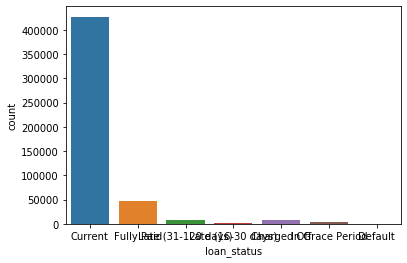

In [30]:
sns.countplot(x='loan_status',data=X)


In [31]:
X['term'] = X['term'].apply(lambda s: np.int8(s.split()[0]))

In [32]:
X['term'].value_counts(normalize=True)

36    0.695965
60    0.304035
Name: term, dtype: float64

In [33]:
print(sorted(X['grade'].unique()))

['A', 'B', 'C', 'D', 'E', 'F', 'G']


In [34]:
X['emp_length'].value_counts(dropna=False).sort_index()

0.0      85614
1.0      33167
2.0      44747
3.0      40629
4.0      31262
5.0      30854
6.0      21977
7.0      17961
8.0      16027
9.0      12622
11.0    160382
Name: emp_length, dtype: int64

(10, 0)

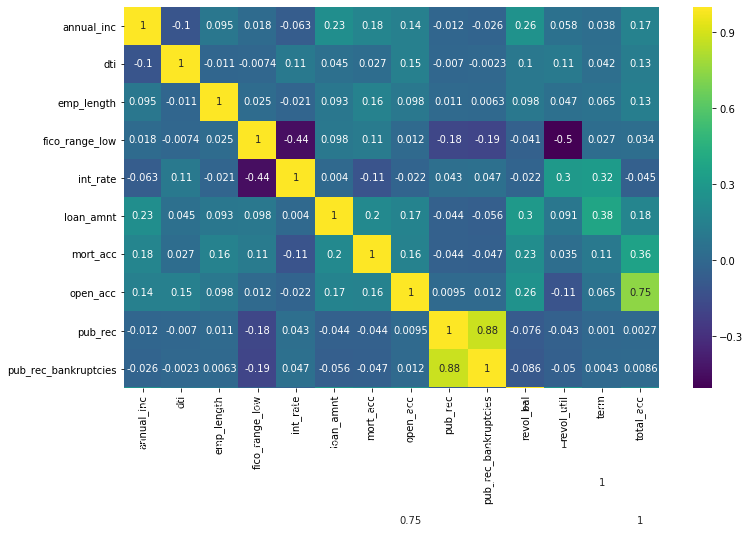

In [35]:
plt.figure(figsize=(12,7))
sns.heatmap(X.corr(),annot=True,cmap='viridis')
plt.ylim(10, 0)

In [36]:
# remove grade F and G, since lending club stopped provideing such loans
X = X[(X['grade']!='G')]
X = X[(X['grade']!='F')]

In [37]:
X.head()

,addr_state,annual_inc,application_type,dti,earliest_cr_line,emp_length,fico_range_low,grade,home_ownership,initial_list_status,...,mort_acc,open_acc,pub_rec,pub_rec_bankruptcies,purpose,revol_bal,revol_util,term,total_acc,verification_status
0,OK,50000.0,Individual,21.80,Jan-2009,8.0,665.0,D,RENT,w,...,0.0,5.0,0.0,0.0,other,116.0,23.2,36,18.0,Verified
1,FL,196000.0,Individual,18.29,Jul-1998,2.0,700.0,B,OWN,w,...,5.0,19.0,0.0,0.0,debt_consolidation,24243.0,46.3,36,53.0,Source Verified
3,AL,65000.0,Individual,12.89,Mar-1995,11.0,665.0,D,MORTGAGE,w,...,2.0,7.0,0.0,0.0,debt_consolidation,8657.0,98.4,60,16.0,Source Verified
4,WA,52000.0,Individual,0.58,Jan-1998,9.0,760.0,A,RENT,w,...,4.0,7.0,0.0,0.0,major_purchase,141.0,0.5,36,30.0,Source Verified
5,FL,52000.0,Individual,15.65,Apr-1999,11.0,670.0,D,RENT,w,...,0.0,9.0,0.0,0.0,debt_consolidation,15363.0,55.9,60,14.0,Source Verified


In [38]:
X.select_dtypes(['object']).columns

Index(['addr_state', 'application_type', 'earliest_cr_line', 'grade',
       'home_ownership', 'initial_list_status', 'loan_status', 'purpose',
       'verification_status'],
      dtype='object')

In [39]:
dummies = pd.get_dummies(X[['verification_status', 'application_type','initial_list_status','purpose','addr_state','grade' ]],drop_first=True)
X = X.drop(['verification_status', 'application_type','initial_list_status','purpose','addr_state','grade'],axis=1)
X = pd.concat([X,dummies],axis=1)

In [40]:
X['home_ownership']=X['home_ownership'].replace(['NONE', 'ANY'], 'OTHER')

dummies = pd.get_dummies(X['home_ownership'],drop_first=True)
X = X.drop('home_ownership',axis=1)
X = pd.concat([X,dummies],axis=1)

In [41]:
X['earliest_cr_year'] = X['earliest_cr_line'].apply(lambda date:int(date[-4:]))
X = X.drop('earliest_cr_line',axis=1)

In [42]:
# check target 
X['loan_status'].value_counts()

Current               424427
Fully Paid             46937
Charged Off             8571
Late (31-120 days)      7033
In Grace Period         2863
Late (16-30 days)       1558
Default                    7
Name: loan_status, dtype: int64

In [43]:
X['loan_repaid'] = X['loan_status'].map({'In Grace Period':1,'Current':1,'Fully Paid':1,'Charged Off':0, 'Late (31-120 days)':0, 'Late (16-30 days)':0, 'Default':0})

In [44]:

#X['loan_repaid'] = X['loan_repaid'].astype('integer')
X['loan_repaid'].values

array([1, 1, 1, ..., 1, 1, 1])

In [45]:
y = X['loan_repaid'].values
X = X.drop(['loan_repaid', 'loan_status'], axis=1, errors='ignore').values

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, test_size=0.25) 

In [93]:
#scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.transform(X_test)

In [94]:
# First try simple model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout,BatchNormalization,Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow import keras

In [131]:
model = Sequential()
# input layer
model.add(Dense(87,  activation='relu', kernel_initializer="he_normal",
                kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(44, activation='relu', kernel_initializer="he_normal",
                kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(BatchNormalization())                                                  
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(22, activation='relu', kernel_initializer="he_normal",
                kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(BatchNormalization())                                                  
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=1,activation='sigmoid', kernel_regularizer=keras.regularizers.l2(0.01)))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [132]:
# TensorBoard
import os
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6007

root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 67844), started 5:17:53 ago. (Use '!kill 67844' to kill it.)

'./my_logs/run_2020_05_21-19_16_52'

In [133]:
# custom callback
class PrintTrainValRatioCb(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [134]:
# fit model
# callbacks: checkpoint, early stopping, tensorboard
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
filepath = "lending_club.hdf5"
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath, 
                                            save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,   
                                     restore_best_weights=True)
train_val_ratio_cb = PrintTrainValRatioCb()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

reduce_lr_cb = keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)


# history = model.fit(train_it, validation_data=test_it, epochs=50, verbose=1, 
#                     steps_per_epoch=len(train_it), validation_steps=len(test_it),
#                              callbacks=[checkpoint_cb, reduce_lr_cb, train_val_ratio_cb, early_stopping_cb, tensorboard_cb])

In [135]:
neg, pos = np.bincount(y_train)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 294837
    Positive: 284563 (96.52% of total)



In [136]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 14.35
Weight for class 1: 0.52


In [137]:
history = model.fit(X_train, y_train,
          epochs=100,
          batch_size=256,
          validation_data=(X_val, y_val),class_weight=class_weight,
          verbose=1,
          callbacks=[checkpoint_cb, reduce_lr_cb, train_val_ratio_cb, early_stopping_cb, tensorboard_cb]
          )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 294837 samples, validate on 98279 samples
Epoch 1/100
294656/294837 [============================>.] - ETA: 21:02 - loss: 4.2930 - accuracy: 0.492 - ETA: 2:00 - loss: 4.0019 - accuracy: 0.506 - ETA: 1:46 - loss: 3.9997 - accuracy: 0.50 - ETA: 1:15 - loss: 3.9419 - accuracy: 0.50 - ETA: 1:04 - loss: 3.9185 - accuracy: 0.51 - ETA: 57s - loss: 3.9038 - accuracy: 0.5106 - ETA: 47s - loss: 3.8618 - accuracy: 0.513 - ETA: 43s - loss: 3.8453 - accuracy: 0.511 - ETA: 37s - loss: 3.7920 - accuracy: 0.510 - ETA: 33s - loss: 3.7385 - accuracy: 0.511 - ETA: 29s - loss: 3.6963 - accuracy: 0.512 - ETA: 27s - loss: 3.6571 - accuracy: 0.514 - ETA: 26s - loss: 3.6303 - accuracy: 0.514 - ETA: 25s - loss: 3.5989 - accuracy: 0.515 - ETA: 24s - loss: 3.5632 - accuracy: 0.516 - ETA: 23s - loss: 3.5424 - accuracy: 0.518 - ETA: 22s - loss: 3.5093 - accuracy: 0.519 - ETA: 21s - loss: 3.4749 - accuracy: 0.521 - ETA: 20s - loss: 3.4545 - accuracy: 0.523 

294656/294837 [============================>.] - ETA: 8s - loss: 0.7910 - accuracy: 0.64 - ETA: 4s - loss: 0.8287 - accuracy: 0.63 - ETA: 4s - loss: 0.8118 - accuracy: 0.63 - ETA: 4s - loss: 0.7940 - accuracy: 0.62 - ETA: 4s - loss: 0.8088 - accuracy: 0.62 - ETA: 4s - loss: 0.8063 - accuracy: 0.62 - ETA: 5s - loss: 0.8087 - accuracy: 0.62 - ETA: 6s - loss: 0.8040 - accuracy: 0.62 - ETA: 6s - loss: 0.8077 - accuracy: 0.62 - ETA: 6s - loss: 0.8055 - accuracy: 0.62 - ETA: 5s - loss: 0.8117 - accuracy: 0.61 - ETA: 5s - loss: 0.8127 - accuracy: 0.61 - ETA: 5s - loss: 0.8101 - accuracy: 0.61 - ETA: 5s - loss: 0.8073 - accuracy: 0.61 - ETA: 5s - loss: 0.8042 - accuracy: 0.61 - ETA: 5s - loss: 0.8042 - accuracy: 0.61 - ETA: 5s - loss: 0.8033 - accuracy: 0.61 - ETA: 5s - loss: 0.8031 - accuracy: 0.60 - ETA: 5s - loss: 0.8026 - accuracy: 0.60 - ETA: 5s - loss: 0.7961 - accuracy: 0.60 - ETA: 5s - loss: 0.7899 - accuracy: 0.60 - ETA: 5s - loss: 0.7909 - accuracy: 0.60 - ETA: 5s - loss: 0.7873 - ac

293120/294837 [============================>.] - ETA: 19s - loss: 0.6902 - accuracy: 0.582 - ETA: 48s - loss: 0.6353 - accuracy: 0.589 - ETA: 22s - loss: 0.7088 - accuracy: 0.578 - ETA: 13s - loss: 0.6697 - accuracy: 0.583 - ETA: 11s - loss: 0.6692 - accuracy: 0.589 - ETA: 9s - loss: 0.6687 - accuracy: 0.592 - ETA: 9s - loss: 0.6737 - accuracy: 0.58 - ETA: 9s - loss: 0.6660 - accuracy: 0.58 - ETA: 9s - loss: 0.6658 - accuracy: 0.58 - ETA: 9s - loss: 0.6793 - accuracy: 0.58 - ETA: 8s - loss: 0.6838 - accuracy: 0.58 - ETA: 8s - loss: 0.6795 - accuracy: 0.58 - ETA: 8s - loss: 0.6811 - accuracy: 0.58 - ETA: 8s - loss: 0.6797 - accuracy: 0.58 - ETA: 8s - loss: 0.6797 - accuracy: 0.58 - ETA: 8s - loss: 0.6781 - accuracy: 0.58 - ETA: 9s - loss: 0.6731 - accuracy: 0.58 - ETA: 9s - loss: 0.6670 - accuracy: 0.58 - ETA: 9s - loss: 0.6689 - accuracy: 0.58 - ETA: 9s - loss: 0.6691 - accuracy: 0.58 - ETA: 8s - loss: 0.6688 - accuracy: 0.58 - ETA: 8s - loss: 0.6680 - accuracy: 0.58 - ETA: 8s - loss: 

294656/294837 [============================>.] - ETA: 21s - loss: 0.6037 - accuracy: 0.578 - ETA: 6s - loss: 0.6302 - accuracy: 0.582 - ETA: 5s - loss: 0.6298 - accuracy: 0.58 - ETA: 5s - loss: 0.6328 - accuracy: 0.58 - ETA: 5s - loss: 0.6263 - accuracy: 0.57 - ETA: 4s - loss: 0.6277 - accuracy: 0.57 - ETA: 4s - loss: 0.6305 - accuracy: 0.56 - ETA: 4s - loss: 0.6314 - accuracy: 0.56 - ETA: 4s - loss: 0.6274 - accuracy: 0.56 - ETA: 4s - loss: 0.6291 - accuracy: 0.56 - ETA: 4s - loss: 0.6294 - accuracy: 0.56 - ETA: 4s - loss: 0.6280 - accuracy: 0.57 - ETA: 4s - loss: 0.6295 - accuracy: 0.57 - ETA: 4s - loss: 0.6314 - accuracy: 0.57 - ETA: 4s - loss: 0.6295 - accuracy: 0.57 - ETA: 4s - loss: 0.6309 - accuracy: 0.57 - ETA: 4s - loss: 0.6335 - accuracy: 0.57 - ETA: 4s - loss: 0.6328 - accuracy: 0.57 - ETA: 4s - loss: 0.6335 - accuracy: 0.57 - ETA: 4s - loss: 0.6331 - accuracy: 0.57 - ETA: 3s - loss: 0.6338 - accuracy: 0.57 - ETA: 3s - loss: 0.6315 - accuracy: 0.58 - ETA: 3s - loss: 0.6330 -

294400/294837 [============================>.] - ETA: 8s - loss: 0.7066 - accuracy: 0.59 - ETA: 4s - loss: 0.6458 - accuracy: 0.57 - ETA: 4s - loss: 0.6492 - accuracy: 0.56 - ETA: 4s - loss: 0.6309 - accuracy: 0.57 - ETA: 4s - loss: 0.6304 - accuracy: 0.57 - ETA: 4s - loss: 0.6347 - accuracy: 0.57 - ETA: 4s - loss: 0.6395 - accuracy: 0.57 - ETA: 4s - loss: 0.6454 - accuracy: 0.57 - ETA: 4s - loss: 0.6537 - accuracy: 0.57 - ETA: 4s - loss: 0.6490 - accuracy: 0.57 - ETA: 4s - loss: 0.6489 - accuracy: 0.57 - ETA: 4s - loss: 0.6429 - accuracy: 0.57 - ETA: 4s - loss: 0.6401 - accuracy: 0.57 - ETA: 4s - loss: 0.6360 - accuracy: 0.57 - ETA: 4s - loss: 0.6364 - accuracy: 0.58 - ETA: 4s - loss: 0.6349 - accuracy: 0.58 - ETA: 3s - loss: 0.6364 - accuracy: 0.58 - ETA: 3s - loss: 0.6396 - accuracy: 0.58 - ETA: 3s - loss: 0.6424 - accuracy: 0.59 - ETA: 3s - loss: 0.6428 - accuracy: 0.59 - ETA: 3s - loss: 0.6432 - accuracy: 0.59 - ETA: 3s - loss: 0.6427 - accuracy: 0.60 - ETA: 3s - loss: 0.6425 - ac

294400/294837 [============================>.] - ETA: 9s - loss: 0.6849 - accuracy: 0.60 - ETA: 38s - loss: 0.6373 - accuracy: 0.609 - ETA: 16s - loss: 0.6182 - accuracy: 0.603 - ETA: 9s - loss: 0.6370 - accuracy: 0.610 - ETA: 7s - loss: 0.6526 - accuracy: 0.61 - ETA: 6s - loss: 0.6685 - accuracy: 0.61 - ETA: 6s - loss: 0.6540 - accuracy: 0.60 - ETA: 6s - loss: 0.6478 - accuracy: 0.60 - ETA: 5s - loss: 0.6419 - accuracy: 0.59 - ETA: 5s - loss: 0.6374 - accuracy: 0.59 - ETA: 5s - loss: 0.6418 - accuracy: 0.58 - ETA: 5s - loss: 0.6401 - accuracy: 0.58 - ETA: 5s - loss: 0.6397 - accuracy: 0.59 - ETA: 5s - loss: 0.6423 - accuracy: 0.59 - ETA: 4s - loss: 0.6408 - accuracy: 0.59 - ETA: 4s - loss: 0.6444 - accuracy: 0.58 - ETA: 4s - loss: 0.6406 - accuracy: 0.58 - ETA: 4s - loss: 0.6394 - accuracy: 0.58 - ETA: 4s - loss: 0.6381 - accuracy: 0.58 - ETA: 4s - loss: 0.6396 - accuracy: 0.59 - ETA: 4s - loss: 0.6402 - accuracy: 0.59 - ETA: 4s - loss: 0.6434 - accuracy: 0.58 - ETA: 4s - loss: 0.6401

294656/294837 [============================>.] - ETA: 14s - loss: 0.6016 - accuracy: 0.617 - ETA: 21s - loss: 0.6101 - accuracy: 0.616 - ETA: 29s - loss: 0.6041 - accuracy: 0.613 - ETA: 41s - loss: 0.6290 - accuracy: 0.614 - ETA: 28s - loss: 0.6054 - accuracy: 0.613 - ETA: 22s - loss: 0.6122 - accuracy: 0.614 - ETA: 18s - loss: 0.5995 - accuracy: 0.620 - ETA: 16s - loss: 0.6006 - accuracy: 0.622 - ETA: 15s - loss: 0.6032 - accuracy: 0.623 - ETA: 14s - loss: 0.6069 - accuracy: 0.625 - ETA: 12s - loss: 0.6146 - accuracy: 0.623 - ETA: 10s - loss: 0.6246 - accuracy: 0.621 - ETA: 9s - loss: 0.6270 - accuracy: 0.614 - ETA: 8s - loss: 0.6223 - accuracy: 0.61 - ETA: 8s - loss: 0.6240 - accuracy: 0.60 - ETA: 7s - loss: 0.6274 - accuracy: 0.60 - ETA: 7s - loss: 0.6247 - accuracy: 0.60 - ETA: 6s - loss: 0.6271 - accuracy: 0.60 - ETA: 6s - loss: 0.6287 - accuracy: 0.60 - ETA: 6s - loss: 0.6281 - accuracy: 0.59 - ETA: 5s - loss: 0.6287 - accuracy: 0.59 - ETA: 5s - loss: 0.6308 - accuracy: 0.59 - ET

292352/294837 [============================>.] - ETA: 21s - loss: 0.4704 - accuracy: 0.605 - ETA: 6s - loss: 0.5771 - accuracy: 0.622 - ETA: 5s - loss: 0.6138 - accuracy: 0.63 - ETA: 5s - loss: 0.6093 - accuracy: 0.63 - ETA: 5s - loss: 0.6264 - accuracy: 0.62 - ETA: 4s - loss: 0.6243 - accuracy: 0.62 - ETA: 4s - loss: 0.6227 - accuracy: 0.61 - ETA: 5s - loss: 0.6252 - accuracy: 0.61 - ETA: 5s - loss: 0.6246 - accuracy: 0.61 - ETA: 4s - loss: 0.6254 - accuracy: 0.60 - ETA: 4s - loss: 0.6287 - accuracy: 0.60 - ETA: 4s - loss: 0.6304 - accuracy: 0.60 - ETA: 4s - loss: 0.6286 - accuracy: 0.60 - ETA: 4s - loss: 0.6333 - accuracy: 0.60 - ETA: 4s - loss: 0.6344 - accuracy: 0.60 - ETA: 4s - loss: 0.6381 - accuracy: 0.60 - ETA: 4s - loss: 0.6365 - accuracy: 0.60 - ETA: 4s - loss: 0.6384 - accuracy: 0.60 - ETA: 4s - loss: 0.6373 - accuracy: 0.60 - ETA: 3s - loss: 0.6406 - accuracy: 0.61 - ETA: 3s - loss: 0.6380 - accuracy: 0.61 - ETA: 3s - loss: 0.6373 - accuracy: 0.61 - ETA: 3s - loss: 0.6384 -

293888/294837 [============================>.] - ETA: 14s - loss: 0.5093 - accuracy: 0.597 - ETA: 6s - loss: 0.6621 - accuracy: 0.606 - ETA: 6s - loss: 0.6295 - accuracy: 0.61 - ETA: 5s - loss: 0.6293 - accuracy: 0.61 - ETA: 5s - loss: 0.6376 - accuracy: 0.61 - ETA: 5s - loss: 0.6324 - accuracy: 0.61 - ETA: 5s - loss: 0.6408 - accuracy: 0.60 - ETA: 5s - loss: 0.6446 - accuracy: 0.60 - ETA: 6s - loss: 0.6444 - accuracy: 0.60 - ETA: 7s - loss: 0.6511 - accuracy: 0.60 - ETA: 7s - loss: 0.6497 - accuracy: 0.60 - ETA: 7s - loss: 0.6517 - accuracy: 0.60 - ETA: 7s - loss: 0.6517 - accuracy: 0.60 - ETA: 7s - loss: 0.6522 - accuracy: 0.60 - ETA: 8s - loss: 0.6524 - accuracy: 0.60 - ETA: 8s - loss: 0.6512 - accuracy: 0.60 - ETA: 8s - loss: 0.6494 - accuracy: 0.60 - ETA: 8s - loss: 0.6480 - accuracy: 0.60 - ETA: 9s - loss: 0.6487 - accuracy: 0.60 - ETA: 9s - loss: 0.6469 - accuracy: 0.60 - ETA: 9s - loss: 0.6439 - accuracy: 0.60 - ETA: 9s - loss: 0.6382 - accuracy: 0.60 - ETA: 8s - loss: 0.6368 -

291840/294837 [============================>.] - ETA: 10s - loss: 0.7786 - accuracy: 0.593 - ETA: 4s - loss: 0.6526 - accuracy: 0.653 - ETA: 4s - loss: 0.6111 - accuracy: 0.65 - ETA: 4s - loss: 0.6208 - accuracy: 0.65 - ETA: 4s - loss: 0.6313 - accuracy: 0.65 - ETA: 4s - loss: 0.6219 - accuracy: 0.65 - ETA: 4s - loss: 0.6075 - accuracy: 0.64 - ETA: 4s - loss: 0.6166 - accuracy: 0.64 - ETA: 4s - loss: 0.6225 - accuracy: 0.63 - ETA: 4s - loss: 0.6259 - accuracy: 0.63 - ETA: 4s - loss: 0.6260 - accuracy: 0.63 - ETA: 4s - loss: 0.6234 - accuracy: 0.63 - ETA: 4s - loss: 0.6234 - accuracy: 0.63 - ETA: 4s - loss: 0.6214 - accuracy: 0.63 - ETA: 4s - loss: 0.6220 - accuracy: 0.64 - ETA: 4s - loss: 0.6221 - accuracy: 0.64 - ETA: 4s - loss: 0.6241 - accuracy: 0.64 - ETA: 4s - loss: 0.6244 - accuracy: 0.64 - ETA: 4s - loss: 0.6223 - accuracy: 0.64 - ETA: 4s - loss: 0.6220 - accuracy: 0.64 - ETA: 3s - loss: 0.6226 - accuracy: 0.64 - ETA: 3s - loss: 0.6208 - accuracy: 0.63 - ETA: 3s - loss: 0.6204 -

292352/294837 [============================>.] - ETA: 8s - loss: 0.6667 - accuracy: 0.60 - ETA: 4s - loss: 0.6043 - accuracy: 0.63 - ETA: 4s - loss: 0.6373 - accuracy: 0.63 - ETA: 4s - loss: 0.6331 - accuracy: 0.64 - ETA: 4s - loss: 0.6290 - accuracy: 0.64 - ETA: 4s - loss: 0.6192 - accuracy: 0.64 - ETA: 4s - loss: 0.6287 - accuracy: 0.63 - ETA: 4s - loss: 0.6271 - accuracy: 0.63 - ETA: 4s - loss: 0.6269 - accuracy: 0.63 - ETA: 4s - loss: 0.6228 - accuracy: 0.63 - ETA: 4s - loss: 0.6251 - accuracy: 0.63 - ETA: 4s - loss: 0.6199 - accuracy: 0.62 - ETA: 4s - loss: 0.6199 - accuracy: 0.62 - ETA: 4s - loss: 0.6206 - accuracy: 0.62 - ETA: 4s - loss: 0.6207 - accuracy: 0.62 - ETA: 4s - loss: 0.6229 - accuracy: 0.62 - ETA: 4s - loss: 0.6211 - accuracy: 0.62 - ETA: 4s - loss: 0.6203 - accuracy: 0.62 - ETA: 4s - loss: 0.6222 - accuracy: 0.62 - ETA: 4s - loss: 0.6228 - accuracy: 0.62 - ETA: 4s - loss: 0.6222 - accuracy: 0.62 - ETA: 3s - loss: 0.6214 - accuracy: 0.62 - ETA: 3s - loss: 0.6241 - ac

293120/294837 [============================>.] - ETA: 10s - loss: 0.6306 - accuracy: 0.601 - ETA: 5s - loss: 0.6272 - accuracy: 0.613 - ETA: 5s - loss: 0.6345 - accuracy: 0.61 - ETA: 4s - loss: 0.6421 - accuracy: 0.61 - ETA: 4s - loss: 0.6339 - accuracy: 0.61 - ETA: 4s - loss: 0.6267 - accuracy: 0.61 - ETA: 4s - loss: 0.6269 - accuracy: 0.61 - ETA: 4s - loss: 0.6278 - accuracy: 0.61 - ETA: 4s - loss: 0.6289 - accuracy: 0.61 - ETA: 4s - loss: 0.6292 - accuracy: 0.61 - ETA: 4s - loss: 0.6234 - accuracy: 0.61 - ETA: 4s - loss: 0.6229 - accuracy: 0.61 - ETA: 4s - loss: 0.6253 - accuracy: 0.61 - ETA: 4s - loss: 0.6232 - accuracy: 0.61 - ETA: 4s - loss: 0.6222 - accuracy: 0.61 - ETA: 4s - loss: 0.6227 - accuracy: 0.61 - ETA: 4s - loss: 0.6226 - accuracy: 0.61 - ETA: 4s - loss: 0.6235 - accuracy: 0.61 - ETA: 4s - loss: 0.6259 - accuracy: 0.61 - ETA: 4s - loss: 0.6235 - accuracy: 0.61 - ETA: 4s - loss: 0.6220 - accuracy: 0.61 - ETA: 4s - loss: 0.6206 - accuracy: 0.61 - ETA: 4s - loss: 0.6225 -

292352/294837 [============================>.] - ETA: 17s - loss: 0.6322 - accuracy: 0.609 - ETA: 7s - loss: 0.6491 - accuracy: 0.636 - ETA: 7s - loss: 0.6200 - accuracy: 0.63 - ETA: 8s - loss: 0.6314 - accuracy: 0.63 - ETA: 9s - loss: 0.6155 - accuracy: 0.63 - ETA: 8s - loss: 0.6123 - accuracy: 0.64 - ETA: 7s - loss: 0.6145 - accuracy: 0.65 - ETA: 6s - loss: 0.6226 - accuracy: 0.65 - ETA: 6s - loss: 0.6202 - accuracy: 0.65 - ETA: 5s - loss: 0.6283 - accuracy: 0.65 - ETA: 5s - loss: 0.6243 - accuracy: 0.64 - ETA: 5s - loss: 0.6262 - accuracy: 0.64 - ETA: 5s - loss: 0.6235 - accuracy: 0.63 - ETA: 4s - loss: 0.6269 - accuracy: 0.63 - ETA: 4s - loss: 0.6274 - accuracy: 0.63 - ETA: 4s - loss: 0.6265 - accuracy: 0.62 - ETA: 4s - loss: 0.6270 - accuracy: 0.62 - ETA: 4s - loss: 0.6228 - accuracy: 0.62 - ETA: 4s - loss: 0.6220 - accuracy: 0.62 - ETA: 4s - loss: 0.6251 - accuracy: 0.61 - ETA: 4s - loss: 0.6257 - accuracy: 0.61 - ETA: 3s - loss: 0.6264 - accuracy: 0.61 - ETA: 3s - loss: 0.6273 -

293632/294837 [============================>.] - ETA: 9s - loss: 0.6232 - accuracy: 0.64 - ETA: 4s - loss: 0.6294 - accuracy: 0.62 - ETA: 4s - loss: 0.6338 - accuracy: 0.61 - ETA: 4s - loss: 0.6379 - accuracy: 0.61 - ETA: 4s - loss: 0.6361 - accuracy: 0.62 - ETA: 4s - loss: 0.6239 - accuracy: 0.61 - ETA: 4s - loss: 0.6191 - accuracy: 0.61 - ETA: 4s - loss: 0.6193 - accuracy: 0.61 - ETA: 4s - loss: 0.6167 - accuracy: 0.61 - ETA: 4s - loss: 0.6235 - accuracy: 0.61 - ETA: 4s - loss: 0.6214 - accuracy: 0.61 - ETA: 4s - loss: 0.6239 - accuracy: 0.61 - ETA: 3s - loss: 0.6230 - accuracy: 0.61 - ETA: 3s - loss: 0.6223 - accuracy: 0.61 - ETA: 3s - loss: 0.6235 - accuracy: 0.61 - ETA: 3s - loss: 0.6232 - accuracy: 0.61 - ETA: 3s - loss: 0.6239 - accuracy: 0.61 - ETA: 3s - loss: 0.6201 - accuracy: 0.61 - ETA: 3s - loss: 0.6207 - accuracy: 0.61 - ETA: 3s - loss: 0.6222 - accuracy: 0.61 - ETA: 3s - loss: 0.6241 - accuracy: 0.61 - ETA: 3s - loss: 0.6245 - accuracy: 0.61 - ETA: 3s - loss: 0.6253 - ac

292864/294837 [============================>.] - ETA: 8s - loss: 0.6352 - accuracy: 0.58 - ETA: 5s - loss: 0.6058 - accuracy: 0.64 - ETA: 4s - loss: 0.6260 - accuracy: 0.63 - ETA: 4s - loss: 0.6300 - accuracy: 0.63 - ETA: 4s - loss: 0.6267 - accuracy: 0.63 - ETA: 4s - loss: 0.6216 - accuracy: 0.63 - ETA: 4s - loss: 0.6078 - accuracy: 0.63 - ETA: 4s - loss: 0.6082 - accuracy: 0.63 - ETA: 4s - loss: 0.6103 - accuracy: 0.63 - ETA: 4s - loss: 0.6137 - accuracy: 0.63 - ETA: 4s - loss: 0.6116 - accuracy: 0.63 - ETA: 3s - loss: 0.6121 - accuracy: 0.63 - ETA: 3s - loss: 0.6162 - accuracy: 0.62 - ETA: 3s - loss: 0.6203 - accuracy: 0.62 - ETA: 3s - loss: 0.6200 - accuracy: 0.62 - ETA: 3s - loss: 0.6194 - accuracy: 0.62 - ETA: 3s - loss: 0.6152 - accuracy: 0.62 - ETA: 3s - loss: 0.6126 - accuracy: 0.62 - ETA: 3s - loss: 0.6135 - accuracy: 0.62 - ETA: 3s - loss: 0.6141 - accuracy: 0.62 - ETA: 3s - loss: 0.6161 - accuracy: 0.62 - ETA: 3s - loss: 0.6171 - accuracy: 0.62 - ETA: 3s - loss: 0.6157 - ac

Epoch 19/100
293120/294837 [============================>.] - ETA: 8s - loss: 0.3749 - accuracy: 0.65 - ETA: 4s - loss: 0.5751 - accuracy: 0.64 - ETA: 4s - loss: 0.5835 - accuracy: 0.64 - ETA: 4s - loss: 0.5986 - accuracy: 0.64 - ETA: 4s - loss: 0.6033 - accuracy: 0.63 - ETA: 4s - loss: 0.6055 - accuracy: 0.63 - ETA: 4s - loss: 0.6111 - accuracy: 0.63 - ETA: 4s - loss: 0.6140 - accuracy: 0.63 - ETA: 4s - loss: 0.6153 - accuracy: 0.63 - ETA: 3s - loss: 0.6088 - accuracy: 0.63 - ETA: 3s - loss: 0.6119 - accuracy: 0.63 - ETA: 3s - loss: 0.6154 - accuracy: 0.63 - ETA: 3s - loss: 0.6184 - accuracy: 0.63 - ETA: 3s - loss: 0.6203 - accuracy: 0.63 - ETA: 3s - loss: 0.6209 - accuracy: 0.63 - ETA: 3s - loss: 0.6200 - accuracy: 0.63 - ETA: 3s - loss: 0.6216 - accuracy: 0.63 - ETA: 3s - loss: 0.6216 - accuracy: 0.63 - ETA: 3s - loss: 0.6186 - accuracy: 0.63 - ETA: 3s - loss: 0.6185 - accuracy: 0.63 - ETA: 3s - loss: 0.6197 - accuracy: 0.63 - ETA: 3s - loss: 0.6179 - accuracy: 0.63 - ETA: 3s - loss

293632/294837 [============================>.] - ETA: 9s - loss: 0.6630 - accuracy: 0.62 - ETA: 7s - loss: 0.6372 - accuracy: 0.60 - ETA: 6s - loss: 0.6008 - accuracy: 0.61 - ETA: 5s - loss: 0.5885 - accuracy: 0.61 - ETA: 5s - loss: 0.6009 - accuracy: 0.62 - ETA: 4s - loss: 0.6059 - accuracy: 0.62 - ETA: 4s - loss: 0.6163 - accuracy: 0.62 - ETA: 4s - loss: 0.6219 - accuracy: 0.62 - ETA: 4s - loss: 0.6174 - accuracy: 0.62 - ETA: 4s - loss: 0.6161 - accuracy: 0.62 - ETA: 5s - loss: 0.6157 - accuracy: 0.62 - ETA: 5s - loss: 0.6152 - accuracy: 0.62 - ETA: 5s - loss: 0.6137 - accuracy: 0.62 - ETA: 5s - loss: 0.6155 - accuracy: 0.62 - ETA: 5s - loss: 0.6116 - accuracy: 0.62 - ETA: 5s - loss: 0.6133 - accuracy: 0.62 - ETA: 5s - loss: 0.6141 - accuracy: 0.62 - ETA: 5s - loss: 0.6148 - accuracy: 0.62 - ETA: 5s - loss: 0.6168 - accuracy: 0.62 - ETA: 5s - loss: 0.6173 - accuracy: 0.62 - ETA: 5s - loss: 0.6195 - accuracy: 0.62 - ETA: 5s - loss: 0.6191 - accuracy: 0.62 - ETA: 5s - loss: 0.6183 - ac

292864/294837 [============================>.] - ETA: 8s - loss: 0.5514 - accuracy: 0.63 - ETA: 4s - loss: 0.5878 - accuracy: 0.63 - ETA: 4s - loss: 0.6179 - accuracy: 0.63 - ETA: 4s - loss: 0.6238 - accuracy: 0.63 - ETA: 4s - loss: 0.6278 - accuracy: 0.63 - ETA: 4s - loss: 0.6266 - accuracy: 0.63 - ETA: 4s - loss: 0.6212 - accuracy: 0.63 - ETA: 4s - loss: 0.6221 - accuracy: 0.63 - ETA: 3s - loss: 0.6231 - accuracy: 0.63 - ETA: 3s - loss: 0.6226 - accuracy: 0.63 - ETA: 3s - loss: 0.6230 - accuracy: 0.63 - ETA: 3s - loss: 0.6237 - accuracy: 0.63 - ETA: 3s - loss: 0.6186 - accuracy: 0.63 - ETA: 3s - loss: 0.6171 - accuracy: 0.63 - ETA: 3s - loss: 0.6138 - accuracy: 0.63 - ETA: 3s - loss: 0.6131 - accuracy: 0.62 - ETA: 3s - loss: 0.6122 - accuracy: 0.62 - ETA: 3s - loss: 0.6131 - accuracy: 0.62 - ETA: 3s - loss: 0.6145 - accuracy: 0.62 - ETA: 3s - loss: 0.6179 - accuracy: 0.62 - ETA: 3s - loss: 0.6166 - accuracy: 0.62 - ETA: 3s - loss: 0.6166 - accuracy: 0.62 - ETA: 3s - loss: 0.6180 - ac

292864/294837 [============================>.] - ETA: 9s - loss: 0.5040 - accuracy: 0.60 - ETA: 4s - loss: 0.6295 - accuracy: 0.62 - ETA: 4s - loss: 0.6197 - accuracy: 0.63 - ETA: 4s - loss: 0.6171 - accuracy: 0.63 - ETA: 4s - loss: 0.6234 - accuracy: 0.63 - ETA: 4s - loss: 0.6127 - accuracy: 0.63 - ETA: 4s - loss: 0.6146 - accuracy: 0.63 - ETA: 4s - loss: 0.6095 - accuracy: 0.63 - ETA: 3s - loss: 0.6083 - accuracy: 0.63 - ETA: 3s - loss: 0.6079 - accuracy: 0.63 - ETA: 3s - loss: 0.6055 - accuracy: 0.64 - ETA: 3s - loss: 0.6040 - accuracy: 0.64 - ETA: 3s - loss: 0.6060 - accuracy: 0.64 - ETA: 3s - loss: 0.6067 - accuracy: 0.64 - ETA: 3s - loss: 0.6054 - accuracy: 0.63 - ETA: 3s - loss: 0.6066 - accuracy: 0.63 - ETA: 3s - loss: 0.6093 - accuracy: 0.63 - ETA: 3s - loss: 0.6095 - accuracy: 0.63 - ETA: 3s - loss: 0.6106 - accuracy: 0.63 - ETA: 3s - loss: 0.6111 - accuracy: 0.63 - ETA: 3s - loss: 0.6109 - accuracy: 0.63 - ETA: 3s - loss: 0.6137 - accuracy: 0.63 - ETA: 3s - loss: 0.6150 - ac

293120/294837 [============================>.] - ETA: 10s - loss: 0.5853 - accuracy: 0.625 - ETA: 4s - loss: 0.5899 - accuracy: 0.638 - ETA: 4s - loss: 0.6152 - accuracy: 0.63 - ETA: 4s - loss: 0.6201 - accuracy: 0.63 - ETA: 4s - loss: 0.6277 - accuracy: 0.63 - ETA: 4s - loss: 0.6227 - accuracy: 0.63 - ETA: 4s - loss: 0.6159 - accuracy: 0.63 - ETA: 4s - loss: 0.6183 - accuracy: 0.63 - ETA: 4s - loss: 0.6162 - accuracy: 0.63 - ETA: 3s - loss: 0.6161 - accuracy: 0.63 - ETA: 3s - loss: 0.6183 - accuracy: 0.63 - ETA: 3s - loss: 0.6145 - accuracy: 0.63 - ETA: 3s - loss: 0.6121 - accuracy: 0.63 - ETA: 3s - loss: 0.6150 - accuracy: 0.63 - ETA: 3s - loss: 0.6155 - accuracy: 0.63 - ETA: 3s - loss: 0.6171 - accuracy: 0.63 - ETA: 3s - loss: 0.6196 - accuracy: 0.63 - ETA: 3s - loss: 0.6199 - accuracy: 0.63 - ETA: 3s - loss: 0.6197 - accuracy: 0.63 - ETA: 3s - loss: 0.6183 - accuracy: 0.63 - ETA: 3s - loss: 0.6212 - accuracy: 0.63 - ETA: 3s - loss: 0.6224 - accuracy: 0.63 - ETA: 3s - loss: 0.6234 -

292864/294837 [============================>.] - ETA: 8s - loss: 0.8356 - accuracy: 0.62 - ETA: 4s - loss: 0.6193 - accuracy: 0.64 - ETA: 4s - loss: 0.5938 - accuracy: 0.63 - ETA: 4s - loss: 0.5955 - accuracy: 0.63 - ETA: 4s - loss: 0.6046 - accuracy: 0.63 - ETA: 4s - loss: 0.6197 - accuracy: 0.63 - ETA: 4s - loss: 0.6122 - accuracy: 0.63 - ETA: 4s - loss: 0.6098 - accuracy: 0.63 - ETA: 4s - loss: 0.6138 - accuracy: 0.63 - ETA: 4s - loss: 0.6145 - accuracy: 0.63 - ETA: 4s - loss: 0.6091 - accuracy: 0.63 - ETA: 4s - loss: 0.6072 - accuracy: 0.63 - ETA: 3s - loss: 0.6086 - accuracy: 0.63 - ETA: 3s - loss: 0.6075 - accuracy: 0.63 - ETA: 3s - loss: 0.6093 - accuracy: 0.63 - ETA: 3s - loss: 0.6089 - accuracy: 0.63 - ETA: 3s - loss: 0.6104 - accuracy: 0.63 - ETA: 3s - loss: 0.6114 - accuracy: 0.63 - ETA: 3s - loss: 0.6130 - accuracy: 0.63 - ETA: 3s - loss: 0.6106 - accuracy: 0.63 - ETA: 3s - loss: 0.6096 - accuracy: 0.63 - ETA: 3s - loss: 0.6080 - accuracy: 0.63 - ETA: 3s - loss: 0.6107 - ac

294837/294837 [==============================] - 6s 19us/sample - loss: 0.6159 - accuracy: 0.6310 - val_loss: 0.6236 - val_accuracy: 0.6568
Epoch 26/100
292352/294837 [============================>.] - ETA: 6s - loss: 0.7483 - accuracy: 0.63 - ETA: 7s - loss: 0.6287 - accuracy: 0.62 - ETA: 7s - loss: 0.6047 - accuracy: 0.62 - ETA: 6s - loss: 0.6005 - accuracy: 0.63 - ETA: 5s - loss: 0.6049 - accuracy: 0.63 - ETA: 5s - loss: 0.6074 - accuracy: 0.63 - ETA: 4s - loss: 0.6163 - accuracy: 0.63 - ETA: 4s - loss: 0.6296 - accuracy: 0.63 - ETA: 4s - loss: 0.6280 - accuracy: 0.63 - ETA: 4s - loss: 0.6280 - accuracy: 0.63 - ETA: 4s - loss: 0.6263 - accuracy: 0.63 - ETA: 4s - loss: 0.6252 - accuracy: 0.63 - ETA: 4s - loss: 0.6204 - accuracy: 0.63 - ETA: 4s - loss: 0.6197 - accuracy: 0.63 - ETA: 3s - loss: 0.6185 - accuracy: 0.63 - ETA: 3s - loss: 0.6190 - accuracy: 0.63 - ETA: 3s - loss: 0.6163 - accuracy: 0.63 - ETA: 3s - loss: 0.6148 - accuracy: 0.63 - ETA: 3s - loss: 0.6172 - accuracy: 0.63 - 

293120/294837 [============================>.] - ETA: 10s - loss: 0.5648 - accuracy: 0.613 - ETA: 4s - loss: 0.6006 - accuracy: 0.613 - ETA: 4s - loss: 0.6121 - accuracy: 0.61 - ETA: 4s - loss: 0.6110 - accuracy: 0.61 - ETA: 4s - loss: 0.6132 - accuracy: 0.62 - ETA: 4s - loss: 0.6182 - accuracy: 0.62 - ETA: 4s - loss: 0.6189 - accuracy: 0.62 - ETA: 4s - loss: 0.6169 - accuracy: 0.62 - ETA: 4s - loss: 0.6171 - accuracy: 0.62 - ETA: 4s - loss: 0.6136 - accuracy: 0.62 - ETA: 4s - loss: 0.6177 - accuracy: 0.62 - ETA: 3s - loss: 0.6160 - accuracy: 0.62 - ETA: 3s - loss: 0.6159 - accuracy: 0.62 - ETA: 3s - loss: 0.6176 - accuracy: 0.62 - ETA: 3s - loss: 0.6212 - accuracy: 0.62 - ETA: 3s - loss: 0.6215 - accuracy: 0.62 - ETA: 3s - loss: 0.6221 - accuracy: 0.62 - ETA: 3s - loss: 0.6233 - accuracy: 0.62 - ETA: 3s - loss: 0.6236 - accuracy: 0.62 - ETA: 3s - loss: 0.6227 - accuracy: 0.62 - ETA: 3s - loss: 0.6229 - accuracy: 0.62 - ETA: 3s - loss: 0.6210 - accuracy: 0.62 - ETA: 3s - loss: 0.6206 -

294144/294837 [============================>.] - ETA: 12s - loss: 0.6645 - accuracy: 0.644 - ETA: 6s - loss: 0.6561 - accuracy: 0.632 - ETA: 5s - loss: 0.6415 - accuracy: 0.63 - ETA: 5s - loss: 0.6175 - accuracy: 0.63 - ETA: 5s - loss: 0.6234 - accuracy: 0.63 - ETA: 5s - loss: 0.6107 - accuracy: 0.63 - ETA: 5s - loss: 0.6128 - accuracy: 0.63 - ETA: 4s - loss: 0.6137 - accuracy: 0.63 - ETA: 4s - loss: 0.6157 - accuracy: 0.63 - ETA: 4s - loss: 0.6132 - accuracy: 0.63 - ETA: 4s - loss: 0.6101 - accuracy: 0.63 - ETA: 4s - loss: 0.6111 - accuracy: 0.62 - ETA: 4s - loss: 0.6129 - accuracy: 0.62 - ETA: 4s - loss: 0.6161 - accuracy: 0.62 - ETA: 4s - loss: 0.6136 - accuracy: 0.62 - ETA: 4s - loss: 0.6110 - accuracy: 0.62 - ETA: 4s - loss: 0.6098 - accuracy: 0.62 - ETA: 4s - loss: 0.6138 - accuracy: 0.62 - ETA: 4s - loss: 0.6132 - accuracy: 0.62 - ETA: 3s - loss: 0.6121 - accuracy: 0.62 - ETA: 3s - loss: 0.6113 - accuracy: 0.62 - ETA: 3s - loss: 0.6092 - accuracy: 0.62 - ETA: 3s - loss: 0.6100 -

294656/294837 [============================>.] - ETA: 10s - loss: 0.5686 - accuracy: 0.648 - ETA: 4s - loss: 0.5820 - accuracy: 0.641 - ETA: 4s - loss: 0.5953 - accuracy: 0.63 - ETA: 6s - loss: 0.5890 - accuracy: 0.63 - ETA: 7s - loss: 0.5905 - accuracy: 0.63 - ETA: 7s - loss: 0.5984 - accuracy: 0.63 - ETA: 6s - loss: 0.5992 - accuracy: 0.63 - ETA: 8s - loss: 0.5981 - accuracy: 0.63 - ETA: 8s - loss: 0.5933 - accuracy: 0.63 - ETA: 8s - loss: 0.5962 - accuracy: 0.63 - ETA: 9s - loss: 0.5993 - accuracy: 0.63 - ETA: 9s - loss: 0.6063 - accuracy: 0.63 - ETA: 9s - loss: 0.6067 - accuracy: 0.63 - ETA: 9s - loss: 0.6128 - accuracy: 0.63 - ETA: 9s - loss: 0.6150 - accuracy: 0.63 - ETA: 9s - loss: 0.6069 - accuracy: 0.63 - ETA: 9s - loss: 0.6064 - accuracy: 0.63 - ETA: 9s - loss: 0.6056 - accuracy: 0.62 - ETA: 9s - loss: 0.6019 - accuracy: 0.62 - ETA: 9s - loss: 0.6032 - accuracy: 0.62 - ETA: 8s - loss: 0.6012 - accuracy: 0.62 - ETA: 8s - loss: 0.6048 - accuracy: 0.62 - ETA: 8s - loss: 0.6046 -

294400/294837 [============================>.] - ETA: 10s - loss: 0.6090 - accuracy: 0.644 - ETA: 17s - loss: 0.5924 - accuracy: 0.634 - ETA: 11s - loss: 0.6049 - accuracy: 0.643 - ETA: 9s - loss: 0.5859 - accuracy: 0.646 - ETA: 8s - loss: 0.5799 - accuracy: 0.64 - ETA: 8s - loss: 0.5991 - accuracy: 0.64 - ETA: 7s - loss: 0.5992 - accuracy: 0.64 - ETA: 7s - loss: 0.6056 - accuracy: 0.64 - ETA: 7s - loss: 0.6096 - accuracy: 0.64 - ETA: 7s - loss: 0.6071 - accuracy: 0.64 - ETA: 7s - loss: 0.6053 - accuracy: 0.64 - ETA: 7s - loss: 0.6034 - accuracy: 0.64 - ETA: 7s - loss: 0.5989 - accuracy: 0.64 - ETA: 7s - loss: 0.5983 - accuracy: 0.64 - ETA: 7s - loss: 0.6034 - accuracy: 0.64 - ETA: 6s - loss: 0.6003 - accuracy: 0.64 - ETA: 6s - loss: 0.6049 - accuracy: 0.64 - ETA: 6s - loss: 0.6055 - accuracy: 0.64 - ETA: 6s - loss: 0.6047 - accuracy: 0.64 - ETA: 6s - loss: 0.6036 - accuracy: 0.64 - ETA: 6s - loss: 0.6055 - accuracy: 0.64 - ETA: 6s - loss: 0.6076 - accuracy: 0.64 - ETA: 6s - loss: 0.60

293888/294837 [============================>.] - ETA: 9s - loss: 0.6287 - accuracy: 0.61 - ETA: 35s - loss: 0.6530 - accuracy: 0.619 - ETA: 21s - loss: 0.6337 - accuracy: 0.623 - ETA: 18s - loss: 0.6670 - accuracy: 0.613 - ETA: 14s - loss: 0.6273 - accuracy: 0.613 - ETA: 12s - loss: 0.6353 - accuracy: 0.611 - ETA: 11s - loss: 0.6427 - accuracy: 0.613 - ETA: 10s - loss: 0.6251 - accuracy: 0.615 - ETA: 10s - loss: 0.6296 - accuracy: 0.613 - ETA: 9s - loss: 0.6276 - accuracy: 0.615 - ETA: 9s - loss: 0.6247 - accuracy: 0.61 - ETA: 9s - loss: 0.6217 - accuracy: 0.61 - ETA: 9s - loss: 0.6174 - accuracy: 0.61 - ETA: 9s - loss: 0.6168 - accuracy: 0.61 - ETA: 8s - loss: 0.6152 - accuracy: 0.61 - ETA: 8s - loss: 0.6163 - accuracy: 0.61 - ETA: 8s - loss: 0.6155 - accuracy: 0.61 - ETA: 8s - loss: 0.6117 - accuracy: 0.61 - ETA: 8s - loss: 0.6149 - accuracy: 0.62 - ETA: 8s - loss: 0.6149 - accuracy: 0.62 - ETA: 8s - loss: 0.6125 - accuracy: 0.62 - ETA: 8s - loss: 0.6138 - accuracy: 0.62 - ETA: 7s - 

293376/294837 [============================>.] - ETA: 9s - loss: 0.5540 - accuracy: 0.62 - ETA: 17s - loss: 0.6343 - accuracy: 0.637 - ETA: 16s - loss: 0.6671 - accuracy: 0.634 - ETA: 15s - loss: 0.6465 - accuracy: 0.629 - ETA: 14s - loss: 0.6367 - accuracy: 0.630 - ETA: 12s - loss: 0.6153 - accuracy: 0.632 - ETA: 12s - loss: 0.6060 - accuracy: 0.632 - ETA: 12s - loss: 0.6049 - accuracy: 0.632 - ETA: 11s - loss: 0.6145 - accuracy: 0.633 - ETA: 10s - loss: 0.6130 - accuracy: 0.631 - ETA: 9s - loss: 0.6147 - accuracy: 0.632 - ETA: 9s - loss: 0.6156 - accuracy: 0.63 - ETA: 9s - loss: 0.6121 - accuracy: 0.63 - ETA: 8s - loss: 0.6143 - accuracy: 0.63 - ETA: 8s - loss: 0.6128 - accuracy: 0.63 - ETA: 8s - loss: 0.6121 - accuracy: 0.62 - ETA: 8s - loss: 0.6126 - accuracy: 0.62 - ETA: 8s - loss: 0.6136 - accuracy: 0.62 - ETA: 7s - loss: 0.6169 - accuracy: 0.62 - ETA: 7s - loss: 0.6148 - accuracy: 0.62 - ETA: 7s - loss: 0.6137 - accuracy: 0.62 - ETA: 7s - loss: 0.6165 - accuracy: 0.62 - ETA: 7s 

293376/294837 [============================>.] - ETA: 14s - loss: 0.5654 - accuracy: 0.632 - ETA: 14s - loss: 0.6722 - accuracy: 0.635 - ETA: 13s - loss: 0.6180 - accuracy: 0.634 - ETA: 15s - loss: 0.6431 - accuracy: 0.634 - ETA: 14s - loss: 0.6150 - accuracy: 0.635 - ETA: 12s - loss: 0.6184 - accuracy: 0.636 - ETA: 11s - loss: 0.6229 - accuracy: 0.638 - ETA: 11s - loss: 0.6216 - accuracy: 0.638 - ETA: 10s - loss: 0.6202 - accuracy: 0.639 - ETA: 10s - loss: 0.6141 - accuracy: 0.640 - ETA: 9s - loss: 0.6118 - accuracy: 0.641 - ETA: 9s - loss: 0.6111 - accuracy: 0.64 - ETA: 8s - loss: 0.6108 - accuracy: 0.64 - ETA: 8s - loss: 0.6181 - accuracy: 0.63 - ETA: 8s - loss: 0.6183 - accuracy: 0.63 - ETA: 8s - loss: 0.6204 - accuracy: 0.63 - ETA: 8s - loss: 0.6191 - accuracy: 0.63 - ETA: 8s - loss: 0.6160 - accuracy: 0.63 - ETA: 7s - loss: 0.6149 - accuracy: 0.63 - ETA: 7s - loss: 0.6174 - accuracy: 0.63 - ETA: 7s - loss: 0.6193 - accuracy: 0.63 - ETA: 7s - loss: 0.6191 - accuracy: 0.63 - ETA: 7

293888/294837 [============================>.] - ETA: 18s - loss: 0.5943 - accuracy: 0.640 - ETA: 38s - loss: 0.6083 - accuracy: 0.630 - ETA: 33s - loss: 0.6228 - accuracy: 0.625 - ETA: 19s - loss: 0.5959 - accuracy: 0.628 - ETA: 13s - loss: 0.5921 - accuracy: 0.630 - ETA: 11s - loss: 0.5940 - accuracy: 0.631 - ETA: 11s - loss: 0.6026 - accuracy: 0.632 - ETA: 10s - loss: 0.6137 - accuracy: 0.633 - ETA: 10s - loss: 0.6167 - accuracy: 0.632 - ETA: 9s - loss: 0.6111 - accuracy: 0.633 - ETA: 9s - loss: 0.6185 - accuracy: 0.63 - ETA: 8s - loss: 0.6136 - accuracy: 0.63 - ETA: 8s - loss: 0.6175 - accuracy: 0.63 - ETA: 8s - loss: 0.6197 - accuracy: 0.63 - ETA: 8s - loss: 0.6162 - accuracy: 0.63 - ETA: 8s - loss: 0.6131 - accuracy: 0.63 - ETA: 8s - loss: 0.6076 - accuracy: 0.63 - ETA: 8s - loss: 0.6062 - accuracy: 0.63 - ETA: 8s - loss: 0.6100 - accuracy: 0.63 - ETA: 7s - loss: 0.6086 - accuracy: 0.63 - ETA: 7s - loss: 0.6069 - accuracy: 0.63 - ETA: 7s - loss: 0.6081 - accuracy: 0.63 - ETA: 7s 

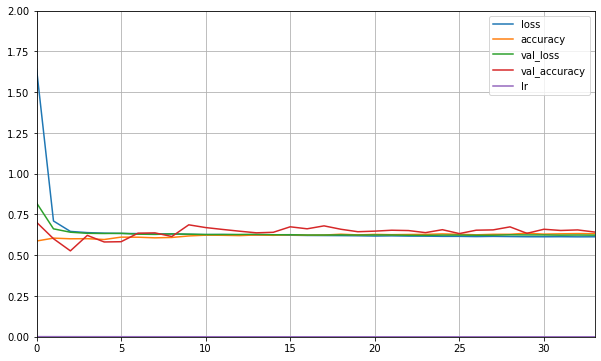

In [138]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(10, 6))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

In [139]:
losses = pd.DataFrame(model.history.history)

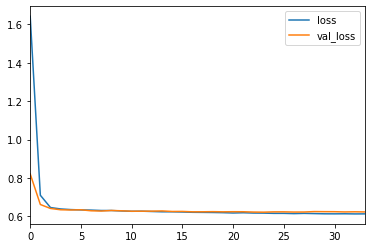

In [140]:
losses[['loss','val_loss']].plot()

In [141]:
from sklearn.metrics import classification_report,confusion_matrix

In [142]:
predictions = model.predict_classes(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.06      0.68      0.12      3441
           1       0.98      0.64      0.77     94839

    accuracy                           0.64     98280
   macro avg       0.52      0.66      0.44     98280
weighted avg       0.95      0.64      0.75     98280



In [143]:
confusion_matrix(y_test,predictions)

array([[ 2335,  1106],
       [34451, 60388]])

In [74]:
pip install -U keras-tuner

Requirement already up-to-date: keras-tuner in /Users/Gulya/anaconda3/lib/python3.7/site-packages (1.0.1)
Note: you may need to restart the kernel to use updated packages.


In [75]:
from kerastuner import HyperModel
class LendClubHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
    def build(self, hp):
        model = keras.Sequential()
        model.add(
            layers.Dense(
                units=hp.Int('units',
                                        min_value=32,
                                        max_value=512,
                                        step=32),
                activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu'),
                input_shape=input_shape,
                kernel_regularizer=keras.regularizers.l2(0.01),
                kernel_initializer="he_normal"
            )
        )
        
        for i in range(hp.Int('num_layers', 1, 6)):
            units = hp.Int(
              'units_' + str(i),
              min_value=60,
              max_value=300,
              step=30
            )

        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(keras.layers.BatchNormalization())
            drop_rate = hp.Choice('drop_rate_' + str(i),
                                [
                                  0.2, 0.5, 0.7
                                ])
            model.add(keras.layers.Dropout(rate=drop_rate))
            model.add(layers.Dense(units=units,
                                   kernel_regularizer=keras.regularizers.l2(0.01),
                                   kernel_initializer="he_normal",
                                   activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')))
        model.add(keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(0.01)))
        optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
        model.compile(
            optimizer=optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

        return model

In [86]:
input_shape = (X_train.shape[1],)
hypermodel = LendClubHyperModel(input_shape)

In [87]:
from kerastuner.tuners import BayesianOptimization
from tensorflow.keras import layers
tuner_bo = BayesianOptimization(
            hypermodel,
            objective='val_accuracy',
            max_trials=5,
            seed=42,
            executions_per_trial=2
        )
tuner_bo.search(X_train, y_train, epochs=10, validation_split=0.2, class_weight=class_weight,verbose=1)


INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [88]:
best_model = tuner_bo.get_best_models(num_models=1)[0]
best_model.evaluate(X_test, y_test)

23034/23034 [==============================] - ETA: 1:31 - loss: 5248.5439 - accuracy: 0.500 - ETA: 4s - loss: 4587.4447 - accuracy: 0.6050  - ETA: 3s - loss: 4776.9087 - accuracy: 0.587 - ETA: 2s - loss: 4567.4731 - accuracy: 0.595 - ETA: 2s - loss: 4544.4181 - accuracy: 0.595 - ETA: 2s - loss: 4583.7839 - accuracy: 0.590 - ETA: 1s - loss: 4496.3107 - accuracy: 0.589 - ETA: 1s - loss: 4443.2889 - accuracy: 0.590 - ETA: 1s - loss: 4453.2726 - accuracy: 0.588 - ETA: 1s - loss: 4442.8560 - accuracy: 0.586 - ETA: 1s - loss: 4457.8093 - accuracy: 0.584 - ETA: 1s - loss: 4436.8071 - accuracy: 0.584 - ETA: 1s - loss: 4445.5370 - accuracy: 0.584 - ETA: 1s - loss: 4446.9094 - accuracy: 0.585 - ETA: 1s - loss: 4433.5838 - accuracy: 0.586 - ETA: 1s - loss: 4437.1541 - accuracy: 0.586 - ETA: 1s - loss: 4424.2289 - accuracy: 0.585 - ETA: 1s - loss: 4430.9705 - accuracy: 0.585 - ETA: 1s - loss: 4435.4253 - accuracy: 0.583 - ETA: 1s - loss: 4408.5707 - accuracy: 0.584 - ETA: 0s - loss: 4400.7021 - a

[4486.574475842776, 0.5847877]

In [79]:
#pip install imbalanced-learn

In [149]:
# try to balance data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_b, y_b = pipeline.fit_resample(X, y)
counter = Counter(y_b)
print(counter)

Counter({1: 94844, 0: 47422})


In [150]:
X_train, X_test, y_train, y_test = train_test_split(X_b, y_b, test_size=0.2, 
                                                    random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, test_size=0.25) 

In [151]:
history = model.fit(X_train, y_train,
          epochs=100,
          batch_size=128,
          validation_data=(X_val, y_val),
          verbose=1,
          callbacks=[checkpoint_cb, reduce_lr_cb, train_val_ratio_cb, early_stopping_cb, tensorboard_cb]
          )

Train on 85359 samples, validate on 28453 samples
Epoch 1/100
84992/85359 [============================>.] - ETA: 8s - loss: 0.5827 - accuracy: 0.71 - ETA: 5s - loss: 0.6378 - accuracy: 0.66 - ETA: 4s - loss: 0.6400 - accuracy: 0.66 - ETA: 4s - loss: 0.6391 - accuracy: 0.66 - ETA: 3s - loss: 0.6402 - accuracy: 0.66 - ETA: 3s - loss: 0.6423 - accuracy: 0.66 - ETA: 3s - loss: 0.6428 - accuracy: 0.66 - ETA: 3s - loss: 0.6409 - accuracy: 0.66 - ETA: 3s - loss: 0.6379 - accuracy: 0.66 - ETA: 3s - loss: 0.6363 - accuracy: 0.66 - ETA: 3s - loss: 0.6364 - accuracy: 0.66 - ETA: 3s - loss: 0.6374 - accuracy: 0.66 - ETA: 3s - loss: 0.6373 - accuracy: 0.66 - ETA: 3s - loss: 0.6364 - accuracy: 0.66 - ETA: 3s - loss: 0.6352 - accuracy: 0.66 - ETA: 3s - loss: 0.6344 - accuracy: 0.67 - ETA: 3s - loss: 0.6345 - accuracy: 0.67 - ETA: 3s - loss: 0.6336 - accuracy: 0.67 - ETA: 3s - loss: 0.6347 - accuracy: 0.67 - ETA: 3s - loss: 0.6349 - accuracy: 0.67 - ETA: 3s - loss: 0.6356 - accuracy: 0.66 - ETA: 3s -

85359/85359 [==============================] - 6s 67us/sample - loss: 0.6263 - accuracy: 0.6722 - val_loss: 0.6279 - val_accuracy: 0.6720
Epoch 3/100
84608/85359 [============================>.] - ETA: 11s - loss: 0.6096 - accuracy: 0.656 - ETA: 6s - loss: 0.6254 - accuracy: 0.668 - ETA: 4s - loss: 0.6195 - accuracy: 0.68 - ETA: 4s - loss: 0.6163 - accuracy: 0.68 - ETA: 4s - loss: 0.6185 - accuracy: 0.68 - ETA: 4s - loss: 0.6179 - accuracy: 0.68 - ETA: 4s - loss: 0.6205 - accuracy: 0.68 - ETA: 4s - loss: 0.6215 - accuracy: 0.68 - ETA: 4s - loss: 0.6242 - accuracy: 0.67 - ETA: 4s - loss: 0.6233 - accuracy: 0.67 - ETA: 4s - loss: 0.6215 - accuracy: 0.67 - ETA: 4s - loss: 0.6225 - accuracy: 0.67 - ETA: 4s - loss: 0.6240 - accuracy: 0.67 - ETA: 4s - loss: 0.6229 - accuracy: 0.67 - ETA: 4s - loss: 0.6222 - accuracy: 0.67 - ETA: 4s - loss: 0.6213 - accuracy: 0.67 - ETA: 4s - loss: 0.6216 - accuracy: 0.67 - ETA: 4s - loss: 0.6213 - accuracy: 0.67 - ETA: 4s - loss: 0.6207 - accuracy: 0.67 - ET

84480/85359 [============================>.] - ETA: 8s - loss: 0.6192 - accuracy: 0.66 - ETA: 13s - loss: 0.6522 - accuracy: 0.632 - ETA: 8s - loss: 0.6234 - accuracy: 0.673 - ETA: 6s - loss: 0.6264 - accuracy: 0.67 - ETA: 5s - loss: 0.6277 - accuracy: 0.67 - ETA: 4s - loss: 0.6264 - accuracy: 0.67 - ETA: 4s - loss: 0.6261 - accuracy: 0.67 - ETA: 4s - loss: 0.6279 - accuracy: 0.67 - ETA: 4s - loss: 0.6290 - accuracy: 0.67 - ETA: 4s - loss: 0.6274 - accuracy: 0.67 - ETA: 5s - loss: 0.6284 - accuracy: 0.67 - ETA: 4s - loss: 0.6265 - accuracy: 0.67 - ETA: 4s - loss: 0.6264 - accuracy: 0.67 - ETA: 5s - loss: 0.6271 - accuracy: 0.67 - ETA: 4s - loss: 0.6265 - accuracy: 0.67 - ETA: 4s - loss: 0.6250 - accuracy: 0.67 - ETA: 4s - loss: 0.6257 - accuracy: 0.67 - ETA: 4s - loss: 0.6252 - accuracy: 0.67 - ETA: 4s - loss: 0.6235 - accuracy: 0.67 - ETA: 4s - loss: 0.6232 - accuracy: 0.67 - ETA: 4s - loss: 0.6240 - accuracy: 0.67 - ETA: 4s - loss: 0.6233 - accuracy: 0.67 - ETA: 4s - loss: 0.6235 - a

84864/85359 [============================>.] - ETA: 4s - loss: 0.6012 - accuracy: 0.70 - ETA: 5s - loss: 0.6099 - accuracy: 0.68 - ETA: 7s - loss: 0.6072 - accuracy: 0.68 - ETA: 6s - loss: 0.6101 - accuracy: 0.68 - ETA: 6s - loss: 0.6126 - accuracy: 0.68 - ETA: 5s - loss: 0.6152 - accuracy: 0.68 - ETA: 4s - loss: 0.6157 - accuracy: 0.68 - ETA: 4s - loss: 0.6207 - accuracy: 0.67 - ETA: 4s - loss: 0.6169 - accuracy: 0.68 - ETA: 4s - loss: 0.6182 - accuracy: 0.67 - ETA: 4s - loss: 0.6213 - accuracy: 0.67 - ETA: 4s - loss: 0.6206 - accuracy: 0.67 - ETA: 4s - loss: 0.6207 - accuracy: 0.67 - ETA: 4s - loss: 0.6189 - accuracy: 0.67 - ETA: 3s - loss: 0.6203 - accuracy: 0.67 - ETA: 3s - loss: 0.6217 - accuracy: 0.67 - ETA: 3s - loss: 0.6218 - accuracy: 0.67 - ETA: 3s - loss: 0.6228 - accuracy: 0.67 - ETA: 3s - loss: 0.6226 - accuracy: 0.67 - ETA: 3s - loss: 0.6234 - accuracy: 0.67 - ETA: 3s - loss: 0.6244 - accuracy: 0.67 - ETA: 3s - loss: 0.6244 - accuracy: 0.67 - ETA: 3s - loss: 0.6246 - accu

84992/85359 [============================>.] - ETA: 8s - loss: 0.6566 - accuracy: 0.63 - ETA: 5s - loss: 0.6108 - accuracy: 0.68 - ETA: 5s - loss: 0.6133 - accuracy: 0.68 - ETA: 5s - loss: 0.6200 - accuracy: 0.67 - ETA: 6s - loss: 0.6191 - accuracy: 0.67 - ETA: 7s - loss: 0.6192 - accuracy: 0.68 - ETA: 6s - loss: 0.6215 - accuracy: 0.67 - ETA: 6s - loss: 0.6255 - accuracy: 0.67 - ETA: 5s - loss: 0.6265 - accuracy: 0.66 - ETA: 5s - loss: 0.6257 - accuracy: 0.66 - ETA: 5s - loss: 0.6250 - accuracy: 0.67 - ETA: 5s - loss: 0.6256 - accuracy: 0.66 - ETA: 5s - loss: 0.6254 - accuracy: 0.67 - ETA: 4s - loss: 0.6262 - accuracy: 0.66 - ETA: 4s - loss: 0.6274 - accuracy: 0.66 - ETA: 5s - loss: 0.6270 - accuracy: 0.66 - ETA: 5s - loss: 0.6261 - accuracy: 0.66 - ETA: 5s - loss: 0.6257 - accuracy: 0.67 - ETA: 5s - loss: 0.6251 - accuracy: 0.67 - ETA: 4s - loss: 0.6251 - accuracy: 0.67 - ETA: 4s - loss: 0.6271 - accuracy: 0.66 - ETA: 4s - loss: 0.6260 - accuracy: 0.66 - ETA: 4s - loss: 0.6259 - accu

84992/85359 [============================>.] - ETA: 5s - loss: 0.6082 - accuracy: 0.67 - ETA: 5s - loss: 0.6220 - accuracy: 0.67 - ETA: 7s - loss: 0.6161 - accuracy: 0.68 - ETA: 8s - loss: 0.6244 - accuracy: 0.66 - ETA: 8s - loss: 0.6219 - accuracy: 0.67 - ETA: 8s - loss: 0.6266 - accuracy: 0.66 - ETA: 7s - loss: 0.6298 - accuracy: 0.66 - ETA: 6s - loss: 0.6286 - accuracy: 0.66 - ETA: 6s - loss: 0.6294 - accuracy: 0.66 - ETA: 5s - loss: 0.6299 - accuracy: 0.66 - ETA: 6s - loss: 0.6301 - accuracy: 0.66 - ETA: 6s - loss: 0.6283 - accuracy: 0.66 - ETA: 6s - loss: 0.6264 - accuracy: 0.66 - ETA: 5s - loss: 0.6269 - accuracy: 0.66 - ETA: 5s - loss: 0.6270 - accuracy: 0.66 - ETA: 5s - loss: 0.6277 - accuracy: 0.66 - ETA: 5s - loss: 0.6251 - accuracy: 0.67 - ETA: 5s - loss: 0.6251 - accuracy: 0.67 - ETA: 5s - loss: 0.6244 - accuracy: 0.67 - ETA: 5s - loss: 0.6244 - accuracy: 0.67 - ETA: 5s - loss: 0.6253 - accuracy: 0.67 - ETA: 5s - loss: 0.6245 - accuracy: 0.67 - ETA: 5s - loss: 0.6243 - accu

84096/85359 [============================>.] - ETA: 5s - loss: 0.6178 - accuracy: 0.66 - ETA: 4s - loss: 0.6128 - accuracy: 0.68 - ETA: 4s - loss: 0.6161 - accuracy: 0.68 - ETA: 4s - loss: 0.6158 - accuracy: 0.68 - ETA: 4s - loss: 0.6151 - accuracy: 0.68 - ETA: 3s - loss: 0.6165 - accuracy: 0.68 - ETA: 3s - loss: 0.6180 - accuracy: 0.68 - ETA: 4s - loss: 0.6206 - accuracy: 0.67 - ETA: 4s - loss: 0.6207 - accuracy: 0.67 - ETA: 4s - loss: 0.6219 - accuracy: 0.67 - ETA: 4s - loss: 0.6248 - accuracy: 0.67 - ETA: 4s - loss: 0.6250 - accuracy: 0.67 - ETA: 4s - loss: 0.6249 - accuracy: 0.67 - ETA: 3s - loss: 0.6253 - accuracy: 0.67 - ETA: 3s - loss: 0.6256 - accuracy: 0.67 - ETA: 3s - loss: 0.6268 - accuracy: 0.66 - ETA: 3s - loss: 0.6273 - accuracy: 0.66 - ETA: 3s - loss: 0.6267 - accuracy: 0.66 - ETA: 3s - loss: 0.6268 - accuracy: 0.66 - ETA: 3s - loss: 0.6271 - accuracy: 0.66 - ETA: 3s - loss: 0.6276 - accuracy: 0.66 - ETA: 3s - loss: 0.6269 - accuracy: 0.66 - ETA: 3s - loss: 0.6263 - accu

84480/85359 [============================>.] - ETA: 9s - loss: 0.6159 - accuracy: 0.69 - ETA: 4s - loss: 0.6272 - accuracy: 0.67 - ETA: 4s - loss: 0.6292 - accuracy: 0.66 - ETA: 3s - loss: 0.6299 - accuracy: 0.66 - ETA: 3s - loss: 0.6284 - accuracy: 0.67 - ETA: 4s - loss: 0.6287 - accuracy: 0.66 - ETA: 4s - loss: 0.6291 - accuracy: 0.66 - ETA: 4s - loss: 0.6288 - accuracy: 0.67 - ETA: 4s - loss: 0.6288 - accuracy: 0.67 - ETA: 4s - loss: 0.6280 - accuracy: 0.67 - ETA: 4s - loss: 0.6292 - accuracy: 0.66 - ETA: 3s - loss: 0.6299 - accuracy: 0.66 - ETA: 3s - loss: 0.6289 - accuracy: 0.66 - ETA: 3s - loss: 0.6279 - accuracy: 0.66 - ETA: 3s - loss: 0.6284 - accuracy: 0.66 - ETA: 3s - loss: 0.6284 - accuracy: 0.66 - ETA: 3s - loss: 0.6281 - accuracy: 0.66 - ETA: 3s - loss: 0.6276 - accuracy: 0.66 - ETA: 3s - loss: 0.6272 - accuracy: 0.66 - ETA: 3s - loss: 0.6276 - accuracy: 0.66 - ETA: 3s - loss: 0.6278 - accuracy: 0.66 - ETA: 3s - loss: 0.6271 - accuracy: 0.66 - ETA: 3s - loss: 0.6266 - accu

85248/85359 [============================>.] - ETA: 4s - loss: 0.5616 - accuracy: 0.73 - ETA: 3s - loss: 0.6240 - accuracy: 0.68 - ETA: 3s - loss: 0.6204 - accuracy: 0.68 - ETA: 3s - loss: 0.6235 - accuracy: 0.67 - ETA: 3s - loss: 0.6252 - accuracy: 0.67 - ETA: 3s - loss: 0.6283 - accuracy: 0.67 - ETA: 3s - loss: 0.6265 - accuracy: 0.67 - ETA: 3s - loss: 0.6260 - accuracy: 0.67 - ETA: 3s - loss: 0.6259 - accuracy: 0.67 - ETA: 3s - loss: 0.6253 - accuracy: 0.67 - ETA: 3s - loss: 0.6261 - accuracy: 0.67 - ETA: 3s - loss: 0.6254 - accuracy: 0.67 - ETA: 3s - loss: 0.6268 - accuracy: 0.67 - ETA: 3s - loss: 0.6267 - accuracy: 0.67 - ETA: 3s - loss: 0.6254 - accuracy: 0.67 - ETA: 3s - loss: 0.6254 - accuracy: 0.67 - ETA: 3s - loss: 0.6254 - accuracy: 0.67 - ETA: 3s - loss: 0.6241 - accuracy: 0.67 - ETA: 2s - loss: 0.6235 - accuracy: 0.67 - ETA: 2s - loss: 0.6238 - accuracy: 0.67 - ETA: 2s - loss: 0.6241 - accuracy: 0.67 - ETA: 2s - loss: 0.6224 - accuracy: 0.67 - ETA: 2s - loss: 0.6238 - accu

84608/85359 [============================>.] - ETA: 7s - loss: 0.6051 - accuracy: 0.71 - ETA: 8s - loss: 0.6111 - accuracy: 0.70 - ETA: 8s - loss: 0.6064 - accuracy: 0.70 - ETA: 7s - loss: 0.6057 - accuracy: 0.70 - ETA: 7s - loss: 0.6152 - accuracy: 0.69 - ETA: 7s - loss: 0.6177 - accuracy: 0.68 - ETA: 6s - loss: 0.6198 - accuracy: 0.68 - ETA: 5s - loss: 0.6202 - accuracy: 0.67 - ETA: 5s - loss: 0.6191 - accuracy: 0.68 - ETA: 5s - loss: 0.6222 - accuracy: 0.67 - ETA: 5s - loss: 0.6216 - accuracy: 0.67 - ETA: 4s - loss: 0.6233 - accuracy: 0.67 - ETA: 4s - loss: 0.6230 - accuracy: 0.67 - ETA: 5s - loss: 0.6245 - accuracy: 0.67 - ETA: 5s - loss: 0.6233 - accuracy: 0.67 - ETA: 5s - loss: 0.6237 - accuracy: 0.67 - ETA: 4s - loss: 0.6239 - accuracy: 0.67 - ETA: 4s - loss: 0.6238 - accuracy: 0.67 - ETA: 4s - loss: 0.6231 - accuracy: 0.67 - ETA: 4s - loss: 0.6227 - accuracy: 0.67 - ETA: 4s - loss: 0.6248 - accuracy: 0.67 - ETA: 4s - loss: 0.6254 - accuracy: 0.67 - ETA: 4s - loss: 0.6256 - accu

84864/85359 [============================>.] - ETA: 5s - loss: 0.6558 - accuracy: 0.65 - ETA: 10s - loss: 0.6332 - accuracy: 0.669 - ETA: 8s - loss: 0.6200 - accuracy: 0.681 - ETA: 8s - loss: 0.6205 - accuracy: 0.67 - ETA: 9s - loss: 0.6218 - accuracy: 0.67 - ETA: 8s - loss: 0.6171 - accuracy: 0.68 - ETA: 7s - loss: 0.6239 - accuracy: 0.67 - ETA: 6s - loss: 0.6243 - accuracy: 0.67 - ETA: 6s - loss: 0.6254 - accuracy: 0.67 - ETA: 5s - loss: 0.6261 - accuracy: 0.66 - ETA: 5s - loss: 0.6239 - accuracy: 0.67 - ETA: 4s - loss: 0.6250 - accuracy: 0.66 - ETA: 4s - loss: 0.6256 - accuracy: 0.66 - ETA: 4s - loss: 0.6250 - accuracy: 0.66 - ETA: 4s - loss: 0.6248 - accuracy: 0.67 - ETA: 4s - loss: 0.6255 - accuracy: 0.66 - ETA: 4s - loss: 0.6255 - accuracy: 0.67 - ETA: 4s - loss: 0.6249 - accuracy: 0.67 - ETA: 4s - loss: 0.6251 - accuracy: 0.67 - ETA: 3s - loss: 0.6243 - accuracy: 0.67 - ETA: 3s - loss: 0.6236 - accuracy: 0.67 - ETA: 3s - loss: 0.6231 - accuracy: 0.67 - ETA: 3s - loss: 0.6233 - a

85120/85359 [============================>.] - ETA: 23s - loss: 0.5961 - accuracy: 0.687 - ETA: 14s - loss: 0.6042 - accuracy: 0.691 - ETA: 10s - loss: 0.6107 - accuracy: 0.684 - ETA: 8s - loss: 0.6126 - accuracy: 0.679 - ETA: 6s - loss: 0.6186 - accuracy: 0.67 - ETA: 6s - loss: 0.6174 - accuracy: 0.67 - ETA: 5s - loss: 0.6175 - accuracy: 0.67 - ETA: 4s - loss: 0.6208 - accuracy: 0.67 - ETA: 4s - loss: 0.6190 - accuracy: 0.67 - ETA: 4s - loss: 0.6184 - accuracy: 0.67 - ETA: 5s - loss: 0.6193 - accuracy: 0.67 - ETA: 5s - loss: 0.6199 - accuracy: 0.67 - ETA: 4s - loss: 0.6194 - accuracy: 0.67 - ETA: 4s - loss: 0.6210 - accuracy: 0.67 - ETA: 4s - loss: 0.6204 - accuracy: 0.67 - ETA: 4s - loss: 0.6212 - accuracy: 0.67 - ETA: 4s - loss: 0.6219 - accuracy: 0.67 - ETA: 4s - loss: 0.6222 - accuracy: 0.67 - ETA: 4s - loss: 0.6228 - accuracy: 0.67 - ETA: 4s - loss: 0.6240 - accuracy: 0.67 - ETA: 3s - loss: 0.6233 - accuracy: 0.67 - ETA: 3s - loss: 0.6237 - accuracy: 0.67 - ETA: 3s - loss: 0.6242

84864/85359 [============================>.] - ETA: 4s - loss: 0.5949 - accuracy: 0.71 - ETA: 5s - loss: 0.6251 - accuracy: 0.67 - ETA: 6s - loss: 0.6350 - accuracy: 0.66 - ETA: 5s - loss: 0.6303 - accuracy: 0.66 - ETA: 4s - loss: 0.6296 - accuracy: 0.66 - ETA: 4s - loss: 0.6318 - accuracy: 0.66 - ETA: 4s - loss: 0.6336 - accuracy: 0.65 - ETA: 4s - loss: 0.6311 - accuracy: 0.66 - ETA: 3s - loss: 0.6296 - accuracy: 0.66 - ETA: 3s - loss: 0.6277 - accuracy: 0.66 - ETA: 3s - loss: 0.6252 - accuracy: 0.66 - ETA: 3s - loss: 0.6246 - accuracy: 0.67 - ETA: 3s - loss: 0.6265 - accuracy: 0.66 - ETA: 3s - loss: 0.6256 - accuracy: 0.66 - ETA: 3s - loss: 0.6257 - accuracy: 0.66 - ETA: 3s - loss: 0.6247 - accuracy: 0.67 - ETA: 3s - loss: 0.6243 - accuracy: 0.67 - ETA: 2s - loss: 0.6243 - accuracy: 0.67 - ETA: 3s - loss: 0.6233 - accuracy: 0.67 - ETA: 2s - loss: 0.6230 - accuracy: 0.67 - ETA: 2s - loss: 0.6215 - accuracy: 0.67 - ETA: 2s - loss: 0.6213 - accuracy: 0.67 - ETA: 2s - loss: 0.6215 - accu

84608/85359 [============================>.] - ETA: 4s - loss: 0.5931 - accuracy: 0.72 - ETA: 3s - loss: 0.6117 - accuracy: 0.68 - ETA: 3s - loss: 0.6155 - accuracy: 0.67 - ETA: 3s - loss: 0.6158 - accuracy: 0.68 - ETA: 3s - loss: 0.6161 - accuracy: 0.67 - ETA: 3s - loss: 0.6208 - accuracy: 0.67 - ETA: 3s - loss: 0.6235 - accuracy: 0.67 - ETA: 3s - loss: 0.6235 - accuracy: 0.67 - ETA: 3s - loss: 0.6215 - accuracy: 0.67 - ETA: 3s - loss: 0.6207 - accuracy: 0.67 - ETA: 3s - loss: 0.6206 - accuracy: 0.67 - ETA: 3s - loss: 0.6231 - accuracy: 0.67 - ETA: 3s - loss: 0.6233 - accuracy: 0.67 - ETA: 3s - loss: 0.6227 - accuracy: 0.67 - ETA: 3s - loss: 0.6217 - accuracy: 0.67 - ETA: 3s - loss: 0.6216 - accuracy: 0.67 - ETA: 3s - loss: 0.6211 - accuracy: 0.67 - ETA: 3s - loss: 0.6209 - accuracy: 0.67 - ETA: 3s - loss: 0.6207 - accuracy: 0.67 - ETA: 2s - loss: 0.6207 - accuracy: 0.67 - ETA: 2s - loss: 0.6208 - accuracy: 0.67 - ETA: 2s - loss: 0.6212 - accuracy: 0.67 - ETA: 2s - loss: 0.6214 - accu

84992/85359 [============================>.] - ETA: 3s - loss: 0.5719 - accuracy: 0.73 - ETA: 3s - loss: 0.6118 - accuracy: 0.68 - ETA: 3s - loss: 0.6110 - accuracy: 0.68 - ETA: 3s - loss: 0.6148 - accuracy: 0.68 - ETA: 3s - loss: 0.6150 - accuracy: 0.68 - ETA: 3s - loss: 0.6157 - accuracy: 0.68 - ETA: 4s - loss: 0.6157 - accuracy: 0.67 - ETA: 4s - loss: 0.6155 - accuracy: 0.67 - ETA: 4s - loss: 0.6148 - accuracy: 0.68 - ETA: 4s - loss: 0.6145 - accuracy: 0.67 - ETA: 4s - loss: 0.6148 - accuracy: 0.67 - ETA: 4s - loss: 0.6144 - accuracy: 0.67 - ETA: 4s - loss: 0.6151 - accuracy: 0.67 - ETA: 4s - loss: 0.6157 - accuracy: 0.67 - ETA: 4s - loss: 0.6171 - accuracy: 0.67 - ETA: 4s - loss: 0.6175 - accuracy: 0.67 - ETA: 4s - loss: 0.6181 - accuracy: 0.67 - ETA: 4s - loss: 0.6187 - accuracy: 0.67 - ETA: 3s - loss: 0.6187 - accuracy: 0.67 - ETA: 3s - loss: 0.6185 - accuracy: 0.67 - ETA: 3s - loss: 0.6188 - accuracy: 0.67 - ETA: 3s - loss: 0.6188 - accuracy: 0.67 - ETA: 3s - loss: 0.6187 - accu

84992/85359 [============================>.] - ETA: 5s - loss: 0.6644 - accuracy: 0.62 - ETA: 4s - loss: 0.6357 - accuracy: 0.65 - ETA: 4s - loss: 0.6238 - accuracy: 0.67 - ETA: 4s - loss: 0.6191 - accuracy: 0.67 - ETA: 4s - loss: 0.6149 - accuracy: 0.67 - ETA: 3s - loss: 0.6166 - accuracy: 0.67 - ETA: 3s - loss: 0.6167 - accuracy: 0.68 - ETA: 3s - loss: 0.6183 - accuracy: 0.67 - ETA: 3s - loss: 0.6191 - accuracy: 0.67 - ETA: 3s - loss: 0.6199 - accuracy: 0.67 - ETA: 3s - loss: 0.6212 - accuracy: 0.67 - ETA: 3s - loss: 0.6234 - accuracy: 0.66 - ETA: 3s - loss: 0.6234 - accuracy: 0.66 - ETA: 3s - loss: 0.6243 - accuracy: 0.66 - ETA: 3s - loss: 0.6249 - accuracy: 0.66 - ETA: 3s - loss: 0.6263 - accuracy: 0.66 - ETA: 3s - loss: 0.6250 - accuracy: 0.66 - ETA: 3s - loss: 0.6244 - accuracy: 0.66 - ETA: 3s - loss: 0.6238 - accuracy: 0.66 - ETA: 2s - loss: 0.6236 - accuracy: 0.67 - ETA: 2s - loss: 0.6236 - accuracy: 0.67 - ETA: 2s - loss: 0.6230 - accuracy: 0.67 - ETA: 2s - loss: 0.6233 - accu

84608/85359 [============================>.] - ETA: 3s - loss: 0.6480 - accuracy: 0.66 - ETA: 2s - loss: 0.6280 - accuracy: 0.66 - ETA: 3s - loss: 0.6268 - accuracy: 0.66 - ETA: 3s - loss: 0.6240 - accuracy: 0.67 - ETA: 3s - loss: 0.6242 - accuracy: 0.67 - ETA: 3s - loss: 0.6231 - accuracy: 0.67 - ETA: 3s - loss: 0.6239 - accuracy: 0.66 - ETA: 3s - loss: 0.6220 - accuracy: 0.67 - ETA: 3s - loss: 0.6228 - accuracy: 0.67 - ETA: 3s - loss: 0.6241 - accuracy: 0.67 - ETA: 3s - loss: 0.6241 - accuracy: 0.67 - ETA: 3s - loss: 0.6231 - accuracy: 0.67 - ETA: 3s - loss: 0.6241 - accuracy: 0.67 - ETA: 3s - loss: 0.6235 - accuracy: 0.67 - ETA: 3s - loss: 0.6248 - accuracy: 0.67 - ETA: 3s - loss: 0.6260 - accuracy: 0.66 - ETA: 3s - loss: 0.6264 - accuracy: 0.66 - ETA: 3s - loss: 0.6258 - accuracy: 0.66 - ETA: 3s - loss: 0.6257 - accuracy: 0.66 - ETA: 3s - loss: 0.6257 - accuracy: 0.66 - ETA: 3s - loss: 0.6249 - accuracy: 0.67 - ETA: 3s - loss: 0.6251 - accuracy: 0.67 - ETA: 3s - loss: 0.6255 - accu

84864/85359 [============================>.] - ETA: 11s - loss: 0.6259 - accuracy: 0.664 - ETA: 7s - loss: 0.6191 - accuracy: 0.678 - ETA: 5s - loss: 0.6222 - accuracy: 0.67 - ETA: 5s - loss: 0.6206 - accuracy: 0.67 - ETA: 5s - loss: 0.6217 - accuracy: 0.67 - ETA: 4s - loss: 0.6198 - accuracy: 0.67 - ETA: 4s - loss: 0.6216 - accuracy: 0.67 - ETA: 4s - loss: 0.6208 - accuracy: 0.67 - ETA: 3s - loss: 0.6178 - accuracy: 0.68 - ETA: 3s - loss: 0.6176 - accuracy: 0.67 - ETA: 3s - loss: 0.6176 - accuracy: 0.67 - ETA: 3s - loss: 0.6178 - accuracy: 0.67 - ETA: 3s - loss: 0.6189 - accuracy: 0.67 - ETA: 3s - loss: 0.6175 - accuracy: 0.67 - ETA: 3s - loss: 0.6181 - accuracy: 0.67 - ETA: 3s - loss: 0.6181 - accuracy: 0.67 - ETA: 3s - loss: 0.6183 - accuracy: 0.67 - ETA: 3s - loss: 0.6189 - accuracy: 0.67 - ETA: 3s - loss: 0.6192 - accuracy: 0.67 - ETA: 3s - loss: 0.6196 - accuracy: 0.67 - ETA: 3s - loss: 0.6194 - accuracy: 0.67 - ETA: 3s - loss: 0.6200 - accuracy: 0.67 - ETA: 3s - loss: 0.6213 - a

85120/85359 [============================>.] - ETA: 4s - loss: 0.7187 - accuracy: 0.56 - ETA: 6s - loss: 0.6601 - accuracy: 0.62 - ETA: 6s - loss: 0.6347 - accuracy: 0.66 - ETA: 4s - loss: 0.6211 - accuracy: 0.67 - ETA: 4s - loss: 0.6159 - accuracy: 0.68 - ETA: 4s - loss: 0.6187 - accuracy: 0.68 - ETA: 3s - loss: 0.6167 - accuracy: 0.68 - ETA: 3s - loss: 0.6197 - accuracy: 0.67 - ETA: 3s - loss: 0.6213 - accuracy: 0.67 - ETA: 3s - loss: 0.6218 - accuracy: 0.67 - ETA: 3s - loss: 0.6225 - accuracy: 0.67 - ETA: 3s - loss: 0.6234 - accuracy: 0.67 - ETA: 3s - loss: 0.6239 - accuracy: 0.67 - ETA: 3s - loss: 0.6245 - accuracy: 0.67 - ETA: 3s - loss: 0.6243 - accuracy: 0.67 - ETA: 3s - loss: 0.6231 - accuracy: 0.67 - ETA: 3s - loss: 0.6231 - accuracy: 0.67 - ETA: 3s - loss: 0.6218 - accuracy: 0.67 - ETA: 3s - loss: 0.6221 - accuracy: 0.67 - ETA: 3s - loss: 0.6215 - accuracy: 0.67 - ETA: 3s - loss: 0.6212 - accuracy: 0.67 - ETA: 2s - loss: 0.6218 - accuracy: 0.67 - ETA: 2s - loss: 0.6214 - accu

85120/85359 [============================>.] - ETA: 4s - loss: 0.6468 - accuracy: 0.64 - ETA: 5s - loss: 0.6246 - accuracy: 0.67 - ETA: 5s - loss: 0.6302 - accuracy: 0.66 - ETA: 5s - loss: 0.6289 - accuracy: 0.66 - ETA: 6s - loss: 0.6286 - accuracy: 0.66 - ETA: 6s - loss: 0.6272 - accuracy: 0.67 - ETA: 5s - loss: 0.6223 - accuracy: 0.67 - ETA: 5s - loss: 0.6230 - accuracy: 0.67 - ETA: 5s - loss: 0.6255 - accuracy: 0.67 - ETA: 5s - loss: 0.6277 - accuracy: 0.66 - ETA: 4s - loss: 0.6260 - accuracy: 0.66 - ETA: 4s - loss: 0.6274 - accuracy: 0.66 - ETA: 4s - loss: 0.6263 - accuracy: 0.66 - ETA: 4s - loss: 0.6262 - accuracy: 0.66 - ETA: 4s - loss: 0.6268 - accuracy: 0.66 - ETA: 4s - loss: 0.6261 - accuracy: 0.66 - ETA: 4s - loss: 0.6260 - accuracy: 0.66 - ETA: 4s - loss: 0.6259 - accuracy: 0.66 - ETA: 4s - loss: 0.6254 - accuracy: 0.66 - ETA: 4s - loss: 0.6247 - accuracy: 0.67 - ETA: 4s - loss: 0.6251 - accuracy: 0.66 - ETA: 4s - loss: 0.6245 - accuracy: 0.67 - ETA: 3s - loss: 0.6240 - accu

Epoch 35/100
84992/85359 [============================>.] - ETA: 13s - loss: 0.6584 - accuracy: 0.632 - ETA: 5s - loss: 0.6207 - accuracy: 0.678 - ETA: 4s - loss: 0.6205 - accuracy: 0.67 - ETA: 4s - loss: 0.6176 - accuracy: 0.67 - ETA: 5s - loss: 0.6186 - accuracy: 0.67 - ETA: 5s - loss: 0.6200 - accuracy: 0.67 - ETA: 4s - loss: 0.6206 - accuracy: 0.67 - ETA: 4s - loss: 0.6222 - accuracy: 0.67 - ETA: 4s - loss: 0.6212 - accuracy: 0.67 - ETA: 4s - loss: 0.6203 - accuracy: 0.67 - ETA: 4s - loss: 0.6200 - accuracy: 0.67 - ETA: 4s - loss: 0.6198 - accuracy: 0.67 - ETA: 4s - loss: 0.6217 - accuracy: 0.67 - ETA: 4s - loss: 0.6223 - accuracy: 0.67 - ETA: 4s - loss: 0.6229 - accuracy: 0.67 - ETA: 4s - loss: 0.6205 - accuracy: 0.67 - ETA: 4s - loss: 0.6207 - accuracy: 0.67 - ETA: 4s - loss: 0.6199 - accuracy: 0.67 - ETA: 3s - loss: 0.6195 - accuracy: 0.67 - ETA: 3s - loss: 0.6186 - accuracy: 0.67 - ETA: 3s - loss: 0.6181 - accuracy: 0.67 - ETA: 3s - loss: 0.6184 - accuracy: 0.67 - ETA: 3s - los

85120/85359 [============================>.] - ETA: 4s - loss: 0.6223 - accuracy: 0.66 - ETA: 9s - loss: 0.6353 - accuracy: 0.65 - ETA: 8s - loss: 0.6287 - accuracy: 0.65 - ETA: 6s - loss: 0.6154 - accuracy: 0.67 - ETA: 5s - loss: 0.6150 - accuracy: 0.67 - ETA: 5s - loss: 0.6206 - accuracy: 0.67 - ETA: 4s - loss: 0.6212 - accuracy: 0.66 - ETA: 4s - loss: 0.6228 - accuracy: 0.66 - ETA: 4s - loss: 0.6241 - accuracy: 0.66 - ETA: 4s - loss: 0.6241 - accuracy: 0.66 - ETA: 4s - loss: 0.6250 - accuracy: 0.66 - ETA: 4s - loss: 0.6232 - accuracy: 0.67 - ETA: 4s - loss: 0.6226 - accuracy: 0.67 - ETA: 4s - loss: 0.6209 - accuracy: 0.67 - ETA: 4s - loss: 0.6210 - accuracy: 0.67 - ETA: 4s - loss: 0.6209 - accuracy: 0.67 - ETA: 4s - loss: 0.6213 - accuracy: 0.67 - ETA: 3s - loss: 0.6214 - accuracy: 0.67 - ETA: 3s - loss: 0.6227 - accuracy: 0.67 - ETA: 3s - loss: 0.6236 - accuracy: 0.67 - ETA: 3s - loss: 0.6225 - accuracy: 0.67 - ETA: 3s - loss: 0.6218 - accuracy: 0.67 - ETA: 3s - loss: 0.6217 - accu

84992/85359 [============================>.] - ETA: 12s - loss: 0.6602 - accuracy: 0.625 - ETA: 26s - loss: 0.6132 - accuracy: 0.679 - ETA: 10s - loss: 0.6302 - accuracy: 0.659 - ETA: 7s - loss: 0.6310 - accuracy: 0.655 - ETA: 7s - loss: 0.6344 - accuracy: 0.65 - ETA: 7s - loss: 0.6321 - accuracy: 0.65 - ETA: 7s - loss: 0.6340 - accuracy: 0.65 - ETA: 6s - loss: 0.6318 - accuracy: 0.66 - ETA: 6s - loss: 0.6298 - accuracy: 0.66 - ETA: 5s - loss: 0.6284 - accuracy: 0.66 - ETA: 5s - loss: 0.6292 - accuracy: 0.66 - ETA: 6s - loss: 0.6289 - accuracy: 0.66 - ETA: 6s - loss: 0.6291 - accuracy: 0.66 - ETA: 6s - loss: 0.6271 - accuracy: 0.66 - ETA: 5s - loss: 0.6253 - accuracy: 0.66 - ETA: 5s - loss: 0.6243 - accuracy: 0.67 - ETA: 5s - loss: 0.6246 - accuracy: 0.66 - ETA: 5s - loss: 0.6232 - accuracy: 0.67 - ETA: 5s - loss: 0.6224 - accuracy: 0.67 - ETA: 5s - loss: 0.6225 - accuracy: 0.67 - ETA: 5s - loss: 0.6234 - accuracy: 0.66 - ETA: 5s - loss: 0.6232 - accuracy: 0.67 - ETA: 5s - loss: 0.6236

84608/85359 [============================>.] - ETA: 26s - loss: 0.6429 - accuracy: 0.656 - ETA: 12s - loss: 0.6354 - accuracy: 0.653 - ETA: 8s - loss: 0.6195 - accuracy: 0.668 - ETA: 8s - loss: 0.6213 - accuracy: 0.67 - ETA: 7s - loss: 0.6201 - accuracy: 0.66 - ETA: 6s - loss: 0.6193 - accuracy: 0.67 - ETA: 6s - loss: 0.6200 - accuracy: 0.67 - ETA: 6s - loss: 0.6187 - accuracy: 0.67 - ETA: 5s - loss: 0.6189 - accuracy: 0.67 - ETA: 5s - loss: 0.6212 - accuracy: 0.66 - ETA: 5s - loss: 0.6218 - accuracy: 0.66 - ETA: 5s - loss: 0.6198 - accuracy: 0.67 - ETA: 5s - loss: 0.6206 - accuracy: 0.67 - ETA: 4s - loss: 0.6201 - accuracy: 0.67 - ETA: 4s - loss: 0.6214 - accuracy: 0.67 - ETA: 4s - loss: 0.6210 - accuracy: 0.67 - ETA: 4s - loss: 0.6220 - accuracy: 0.67 - ETA: 4s - loss: 0.6205 - accuracy: 0.67 - ETA: 4s - loss: 0.6208 - accuracy: 0.67 - ETA: 3s - loss: 0.6217 - accuracy: 0.67 - ETA: 3s - loss: 0.6203 - accuracy: 0.67 - ETA: 3s - loss: 0.6207 - accuracy: 0.67 - ETA: 3s - loss: 0.6211 -

84608/85359 [============================>.] - ETA: 9s - loss: 0.5976 - accuracy: 0.70 - ETA: 8s - loss: 0.6109 - accuracy: 0.68 - ETA: 7s - loss: 0.6150 - accuracy: 0.68 - ETA: 7s - loss: 0.6116 - accuracy: 0.68 - ETA: 6s - loss: 0.6145 - accuracy: 0.68 - ETA: 5s - loss: 0.6142 - accuracy: 0.68 - ETA: 5s - loss: 0.6165 - accuracy: 0.67 - ETA: 5s - loss: 0.6161 - accuracy: 0.67 - ETA: 5s - loss: 0.6197 - accuracy: 0.67 - ETA: 4s - loss: 0.6203 - accuracy: 0.67 - ETA: 4s - loss: 0.6192 - accuracy: 0.67 - ETA: 4s - loss: 0.6181 - accuracy: 0.67 - ETA: 4s - loss: 0.6180 - accuracy: 0.67 - ETA: 4s - loss: 0.6197 - accuracy: 0.67 - ETA: 4s - loss: 0.6203 - accuracy: 0.67 - ETA: 4s - loss: 0.6205 - accuracy: 0.67 - ETA: 4s - loss: 0.6209 - accuracy: 0.67 - ETA: 3s - loss: 0.6201 - accuracy: 0.67 - ETA: 3s - loss: 0.6191 - accuracy: 0.67 - ETA: 3s - loss: 0.6189 - accuracy: 0.67 - ETA: 4s - loss: 0.6186 - accuracy: 0.67 - ETA: 3s - loss: 0.6193 - accuracy: 0.67 - ETA: 4s - loss: 0.6192 - accu

84864/85359 [============================>.] - ETA: 11s - loss: 0.5715 - accuracy: 0.742 - ETA: 15s - loss: 0.6258 - accuracy: 0.679 - ETA: 11s - loss: 0.6243 - accuracy: 0.673 - ETA: 7s - loss: 0.6168 - accuracy: 0.676 - ETA: 5s - loss: 0.6237 - accuracy: 0.66 - ETA: 6s - loss: 0.6220 - accuracy: 0.67 - ETA: 6s - loss: 0.6240 - accuracy: 0.67 - ETA: 5s - loss: 0.6238 - accuracy: 0.67 - ETA: 6s - loss: 0.6232 - accuracy: 0.67 - ETA: 6s - loss: 0.6249 - accuracy: 0.67 - ETA: 5s - loss: 0.6228 - accuracy: 0.67 - ETA: 5s - loss: 0.6232 - accuracy: 0.67 - ETA: 5s - loss: 0.6230 - accuracy: 0.67 - ETA: 5s - loss: 0.6233 - accuracy: 0.67 - ETA: 5s - loss: 0.6244 - accuracy: 0.66 - ETA: 4s - loss: 0.6224 - accuracy: 0.67 - ETA: 4s - loss: 0.6226 - accuracy: 0.67 - ETA: 4s - loss: 0.6222 - accuracy: 0.67 - ETA: 4s - loss: 0.6224 - accuracy: 0.67 - ETA: 4s - loss: 0.6224 - accuracy: 0.67 - ETA: 4s - loss: 0.6235 - accuracy: 0.66 - ETA: 4s - loss: 0.6231 - accuracy: 0.66 - ETA: 4s - loss: 0.6234

84736/85359 [============================>.] - ETA: 10s - loss: 0.5804 - accuracy: 0.734 - ETA: 4s - loss: 0.6130 - accuracy: 0.679 - ETA: 4s - loss: 0.6098 - accuracy: 0.68 - ETA: 4s - loss: 0.6119 - accuracy: 0.68 - ETA: 4s - loss: 0.6165 - accuracy: 0.67 - ETA: 4s - loss: 0.6160 - accuracy: 0.67 - ETA: 4s - loss: 0.6182 - accuracy: 0.67 - ETA: 4s - loss: 0.6183 - accuracy: 0.67 - ETA: 4s - loss: 0.6168 - accuracy: 0.67 - ETA: 3s - loss: 0.6166 - accuracy: 0.67 - ETA: 3s - loss: 0.6173 - accuracy: 0.67 - ETA: 3s - loss: 0.6159 - accuracy: 0.68 - ETA: 3s - loss: 0.6160 - accuracy: 0.68 - ETA: 4s - loss: 0.6168 - accuracy: 0.67 - ETA: 3s - loss: 0.6177 - accuracy: 0.67 - ETA: 3s - loss: 0.6168 - accuracy: 0.67 - ETA: 4s - loss: 0.6170 - accuracy: 0.67 - ETA: 4s - loss: 0.6177 - accuracy: 0.67 - ETA: 4s - loss: 0.6180 - accuracy: 0.67 - ETA: 4s - loss: 0.6183 - accuracy: 0.67 - ETA: 4s - loss: 0.6178 - accuracy: 0.67 - ETA: 4s - loss: 0.6192 - accuracy: 0.67 - ETA: 4s - loss: 0.6194 - a

84736/85359 [============================>.] - ETA: 11s - loss: 0.5850 - accuracy: 0.687 - ETA: 9s - loss: 0.6053 - accuracy: 0.675 - ETA: 9s - loss: 0.6098 - accuracy: 0.67 - ETA: 7s - loss: 0.6160 - accuracy: 0.67 - ETA: 6s - loss: 0.6175 - accuracy: 0.67 - ETA: 6s - loss: 0.6214 - accuracy: 0.66 - ETA: 5s - loss: 0.6147 - accuracy: 0.67 - ETA: 5s - loss: 0.6124 - accuracy: 0.67 - ETA: 5s - loss: 0.6143 - accuracy: 0.67 - ETA: 5s - loss: 0.6168 - accuracy: 0.66 - ETA: 5s - loss: 0.6156 - accuracy: 0.67 - ETA: 5s - loss: 0.6172 - accuracy: 0.66 - ETA: 5s - loss: 0.6177 - accuracy: 0.66 - ETA: 5s - loss: 0.6170 - accuracy: 0.67 - ETA: 5s - loss: 0.6187 - accuracy: 0.66 - ETA: 5s - loss: 0.6189 - accuracy: 0.66 - ETA: 5s - loss: 0.6179 - accuracy: 0.66 - ETA: 5s - loss: 0.6168 - accuracy: 0.66 - ETA: 5s - loss: 0.6183 - accuracy: 0.66 - ETA: 4s - loss: 0.6178 - accuracy: 0.66 - ETA: 4s - loss: 0.6174 - accuracy: 0.66 - ETA: 4s - loss: 0.6164 - accuracy: 0.67 - ETA: 4s - loss: 0.6168 - a

Epoch 45/100
84864/85359 [============================>.] - ETA: 7s - loss: 0.6221 - accuracy: 0.67 - ETA: 10s - loss: 0.6301 - accuracy: 0.668 - ETA: 12s - loss: 0.6263 - accuracy: 0.664 - ETA: 11s - loss: 0.6109 - accuracy: 0.677 - ETA: 9s - loss: 0.6102 - accuracy: 0.673 - ETA: 7s - loss: 0.6086 - accuracy: 0.67 - ETA: 6s - loss: 0.6118 - accuracy: 0.67 - ETA: 6s - loss: 0.6140 - accuracy: 0.66 - ETA: 7s - loss: 0.6135 - accuracy: 0.66 - ETA: 6s - loss: 0.6124 - accuracy: 0.67 - ETA: 6s - loss: 0.6131 - accuracy: 0.67 - ETA: 6s - loss: 0.6130 - accuracy: 0.67 - ETA: 6s - loss: 0.6143 - accuracy: 0.67 - ETA: 5s - loss: 0.6127 - accuracy: 0.67 - ETA: 5s - loss: 0.6120 - accuracy: 0.67 - ETA: 5s - loss: 0.6099 - accuracy: 0.67 - ETA: 5s - loss: 0.6110 - accuracy: 0.67 - ETA: 5s - loss: 0.6104 - accuracy: 0.67 - ETA: 5s - loss: 0.6096 - accuracy: 0.67 - ETA: 4s - loss: 0.6103 - accuracy: 0.67 - ETA: 4s - loss: 0.6099 - accuracy: 0.67 - ETA: 4s - loss: 0.6103 - accuracy: 0.67 - ETA: 4s -

85120/85359 [============================>.] - ETA: 14s - loss: 0.5861 - accuracy: 0.703 - ETA: 10s - loss: 0.6138 - accuracy: 0.665 - ETA: 8s - loss: 0.6076 - accuracy: 0.672 - ETA: 6s - loss: 0.6118 - accuracy: 0.66 - ETA: 5s - loss: 0.6060 - accuracy: 0.67 - ETA: 5s - loss: 0.6050 - accuracy: 0.67 - ETA: 5s - loss: 0.6056 - accuracy: 0.67 - ETA: 5s - loss: 0.6046 - accuracy: 0.67 - ETA: 4s - loss: 0.6058 - accuracy: 0.67 - ETA: 5s - loss: 0.6074 - accuracy: 0.67 - ETA: 4s - loss: 0.6075 - accuracy: 0.67 - ETA: 4s - loss: 0.6069 - accuracy: 0.67 - ETA: 4s - loss: 0.6075 - accuracy: 0.67 - ETA: 4s - loss: 0.6072 - accuracy: 0.67 - ETA: 4s - loss: 0.6064 - accuracy: 0.67 - ETA: 4s - loss: 0.6066 - accuracy: 0.67 - ETA: 4s - loss: 0.6071 - accuracy: 0.67 - ETA: 4s - loss: 0.6058 - accuracy: 0.67 - ETA: 4s - loss: 0.6061 - accuracy: 0.67 - ETA: 4s - loss: 0.6062 - accuracy: 0.67 - ETA: 4s - loss: 0.6072 - accuracy: 0.67 - ETA: 4s - loss: 0.6083 - accuracy: 0.67 - ETA: 4s - loss: 0.6073 -

85120/85359 [============================>.] - ETA: 12s - loss: 0.6031 - accuracy: 0.710 - ETA: 23s - loss: 0.5893 - accuracy: 0.695 - ETA: 16s - loss: 0.5919 - accuracy: 0.687 - ETA: 13s - loss: 0.6168 - accuracy: 0.663 - ETA: 8s - loss: 0.6093 - accuracy: 0.668 - ETA: 6s - loss: 0.6073 - accuracy: 0.67 - ETA: 6s - loss: 0.6081 - accuracy: 0.67 - ETA: 7s - loss: 0.6080 - accuracy: 0.67 - ETA: 6s - loss: 0.6054 - accuracy: 0.67 - ETA: 5s - loss: 0.6048 - accuracy: 0.67 - ETA: 5s - loss: 0.6048 - accuracy: 0.67 - ETA: 5s - loss: 0.6047 - accuracy: 0.67 - ETA: 5s - loss: 0.6039 - accuracy: 0.67 - ETA: 4s - loss: 0.6061 - accuracy: 0.67 - ETA: 4s - loss: 0.6063 - accuracy: 0.67 - ETA: 4s - loss: 0.6062 - accuracy: 0.67 - ETA: 4s - loss: 0.6052 - accuracy: 0.67 - ETA: 4s - loss: 0.6034 - accuracy: 0.67 - ETA: 4s - loss: 0.6044 - accuracy: 0.67 - ETA: 4s - loss: 0.6037 - accuracy: 0.67 - ETA: 4s - loss: 0.6043 - accuracy: 0.67 - ETA: 4s - loss: 0.6033 - accuracy: 0.67 - ETA: 4s - loss: 0.60

85120/85359 [============================>.] - ETA: 7s - loss: 0.6499 - accuracy: 0.61 - ETA: 25s - loss: 0.6275 - accuracy: 0.660 - ETA: 12s - loss: 0.6088 - accuracy: 0.668 - ETA: 7s - loss: 0.6093 - accuracy: 0.668 - ETA: 6s - loss: 0.6020 - accuracy: 0.67 - ETA: 5s - loss: 0.6064 - accuracy: 0.66 - ETA: 5s - loss: 0.6021 - accuracy: 0.67 - ETA: 5s - loss: 0.5993 - accuracy: 0.67 - ETA: 4s - loss: 0.5979 - accuracy: 0.67 - ETA: 4s - loss: 0.5943 - accuracy: 0.68 - ETA: 4s - loss: 0.5969 - accuracy: 0.67 - ETA: 4s - loss: 0.5966 - accuracy: 0.68 - ETA: 4s - loss: 0.5955 - accuracy: 0.68 - ETA: 4s - loss: 0.5956 - accuracy: 0.68 - ETA: 4s - loss: 0.5944 - accuracy: 0.68 - ETA: 3s - loss: 0.5962 - accuracy: 0.68 - ETA: 3s - loss: 0.5975 - accuracy: 0.67 - ETA: 4s - loss: 0.5974 - accuracy: 0.68 - ETA: 3s - loss: 0.5983 - accuracy: 0.67 - ETA: 3s - loss: 0.5989 - accuracy: 0.67 - ETA: 3s - loss: 0.5979 - accuracy: 0.67 - ETA: 3s - loss: 0.5990 - accuracy: 0.67 - ETA: 3s - loss: 0.5990 -

84992/85359 [============================>.] - ETA: 5s - loss: 0.6023 - accuracy: 0.67 - ETA: 6s - loss: 0.5899 - accuracy: 0.68 - ETA: 6s - loss: 0.5933 - accuracy: 0.68 - ETA: 5s - loss: 0.5852 - accuracy: 0.69 - ETA: 5s - loss: 0.5885 - accuracy: 0.68 - ETA: 4s - loss: 0.5908 - accuracy: 0.68 - ETA: 4s - loss: 0.5889 - accuracy: 0.68 - ETA: 4s - loss: 0.5917 - accuracy: 0.68 - ETA: 4s - loss: 0.5950 - accuracy: 0.67 - ETA: 4s - loss: 0.5945 - accuracy: 0.68 - ETA: 4s - loss: 0.5959 - accuracy: 0.68 - ETA: 4s - loss: 0.5946 - accuracy: 0.68 - ETA: 4s - loss: 0.5947 - accuracy: 0.68 - ETA: 4s - loss: 0.5951 - accuracy: 0.68 - ETA: 4s - loss: 0.5950 - accuracy: 0.68 - ETA: 4s - loss: 0.5947 - accuracy: 0.68 - ETA: 4s - loss: 0.5939 - accuracy: 0.68 - ETA: 3s - loss: 0.5937 - accuracy: 0.68 - ETA: 3s - loss: 0.5949 - accuracy: 0.68 - ETA: 3s - loss: 0.5953 - accuracy: 0.68 - ETA: 3s - loss: 0.5962 - accuracy: 0.68 - ETA: 3s - loss: 0.5953 - accuracy: 0.68 - ETA: 3s - loss: 0.5947 - accu

Epoch 51/100
85120/85359 [============================>.] - ETA: 7s - loss: 0.5936 - accuracy: 0.71 - ETA: 6s - loss: 0.6036 - accuracy: 0.68 - ETA: 5s - loss: 0.5861 - accuracy: 0.69 - ETA: 4s - loss: 0.5891 - accuracy: 0.68 - ETA: 4s - loss: 0.5908 - accuracy: 0.68 - ETA: 5s - loss: 0.5919 - accuracy: 0.68 - ETA: 4s - loss: 0.5902 - accuracy: 0.68 - ETA: 4s - loss: 0.5865 - accuracy: 0.69 - ETA: 4s - loss: 0.5868 - accuracy: 0.68 - ETA: 4s - loss: 0.5872 - accuracy: 0.68 - ETA: 4s - loss: 0.5863 - accuracy: 0.68 - ETA: 3s - loss: 0.5889 - accuracy: 0.68 - ETA: 3s - loss: 0.5885 - accuracy: 0.68 - ETA: 3s - loss: 0.5882 - accuracy: 0.68 - ETA: 3s - loss: 0.5879 - accuracy: 0.68 - ETA: 3s - loss: 0.5877 - accuracy: 0.68 - ETA: 3s - loss: 0.5881 - accuracy: 0.68 - ETA: 3s - loss: 0.5886 - accuracy: 0.68 - ETA: 3s - loss: 0.5899 - accuracy: 0.68 - ETA: 2s - loss: 0.5897 - accuracy: 0.68 - ETA: 2s - loss: 0.5892 - accuracy: 0.68 - ETA: 2s - loss: 0.5891 - accuracy: 0.68 - ETA: 2s - loss: 

84608/85359 [============================>.] - ETA: 4s - loss: 0.5723 - accuracy: 0.69 - ETA: 4s - loss: 0.5918 - accuracy: 0.69 - ETA: 3s - loss: 0.5836 - accuracy: 0.69 - ETA: 3s - loss: 0.5862 - accuracy: 0.69 - ETA: 3s - loss: 0.5872 - accuracy: 0.68 - ETA: 3s - loss: 0.5874 - accuracy: 0.69 - ETA: 3s - loss: 0.5857 - accuracy: 0.69 - ETA: 3s - loss: 0.5870 - accuracy: 0.68 - ETA: 3s - loss: 0.5869 - accuracy: 0.68 - ETA: 3s - loss: 0.5861 - accuracy: 0.68 - ETA: 3s - loss: 0.5866 - accuracy: 0.68 - ETA: 3s - loss: 0.5862 - accuracy: 0.68 - ETA: 3s - loss: 0.5859 - accuracy: 0.68 - ETA: 3s - loss: 0.5861 - accuracy: 0.68 - ETA: 3s - loss: 0.5865 - accuracy: 0.68 - ETA: 3s - loss: 0.5867 - accuracy: 0.68 - ETA: 3s - loss: 0.5862 - accuracy: 0.68 - ETA: 3s - loss: 0.5866 - accuracy: 0.68 - ETA: 3s - loss: 0.5865 - accuracy: 0.68 - ETA: 3s - loss: 0.5858 - accuracy: 0.68 - ETA: 2s - loss: 0.5849 - accuracy: 0.68 - ETA: 2s - loss: 0.5846 - accuracy: 0.68 - ETA: 2s - loss: 0.5842 - accu

84864/85359 [============================>.] - ETA: 3s - loss: 0.5330 - accuracy: 0.73 - ETA: 5s - loss: 0.5751 - accuracy: 0.70 - ETA: 5s - loss: 0.5848 - accuracy: 0.68 - ETA: 4s - loss: 0.5895 - accuracy: 0.67 - ETA: 3s - loss: 0.5844 - accuracy: 0.68 - ETA: 4s - loss: 0.5853 - accuracy: 0.68 - ETA: 3s - loss: 0.5828 - accuracy: 0.68 - ETA: 3s - loss: 0.5870 - accuracy: 0.68 - ETA: 3s - loss: 0.5872 - accuracy: 0.68 - ETA: 3s - loss: 0.5866 - accuracy: 0.68 - ETA: 3s - loss: 0.5892 - accuracy: 0.67 - ETA: 3s - loss: 0.5895 - accuracy: 0.68 - ETA: 3s - loss: 0.5882 - accuracy: 0.68 - ETA: 3s - loss: 0.5880 - accuracy: 0.68 - ETA: 3s - loss: 0.5888 - accuracy: 0.68 - ETA: 3s - loss: 0.5887 - accuracy: 0.68 - ETA: 3s - loss: 0.5880 - accuracy: 0.68 - ETA: 3s - loss: 0.5877 - accuracy: 0.68 - ETA: 3s - loss: 0.5883 - accuracy: 0.68 - ETA: 3s - loss: 0.5884 - accuracy: 0.67 - ETA: 3s - loss: 0.5890 - accuracy: 0.67 - ETA: 2s - loss: 0.5879 - accuracy: 0.68 - ETA: 2s - loss: 0.5881 - accu

84992/85359 [============================>.] - ETA: 11s - loss: 0.6329 - accuracy: 0.617 - ETA: 9s - loss: 0.5945 - accuracy: 0.662 - ETA: 6s - loss: 0.5959 - accuracy: 0.66 - ETA: 4s - loss: 0.5850 - accuracy: 0.67 - ETA: 4s - loss: 0.5844 - accuracy: 0.68 - ETA: 4s - loss: 0.5852 - accuracy: 0.68 - ETA: 3s - loss: 0.5870 - accuracy: 0.68 - ETA: 3s - loss: 0.5873 - accuracy: 0.68 - ETA: 3s - loss: 0.5868 - accuracy: 0.68 - ETA: 3s - loss: 0.5851 - accuracy: 0.68 - ETA: 3s - loss: 0.5837 - accuracy: 0.68 - ETA: 3s - loss: 0.5850 - accuracy: 0.68 - ETA: 3s - loss: 0.5867 - accuracy: 0.68 - ETA: 3s - loss: 0.5854 - accuracy: 0.68 - ETA: 3s - loss: 0.5859 - accuracy: 0.68 - ETA: 3s - loss: 0.5846 - accuracy: 0.68 - ETA: 2s - loss: 0.5853 - accuracy: 0.68 - ETA: 2s - loss: 0.5842 - accuracy: 0.68 - ETA: 2s - loss: 0.5841 - accuracy: 0.68 - ETA: 2s - loss: 0.5837 - accuracy: 0.68 - ETA: 2s - loss: 0.5836 - accuracy: 0.68 - ETA: 2s - loss: 0.5835 - accuracy: 0.68 - ETA: 2s - loss: 0.5828 - a

84864/85359 [============================>.] - ETA: 14s - loss: 0.5799 - accuracy: 0.695 - ETA: 13s - loss: 0.5912 - accuracy: 0.666 - ETA: 10s - loss: 0.5667 - accuracy: 0.699 - ETA: 7s - loss: 0.5808 - accuracy: 0.688 - ETA: 6s - loss: 0.5801 - accuracy: 0.68 - ETA: 6s - loss: 0.5759 - accuracy: 0.68 - ETA: 6s - loss: 0.5780 - accuracy: 0.68 - ETA: 6s - loss: 0.5824 - accuracy: 0.68 - ETA: 6s - loss: 0.5805 - accuracy: 0.67 - ETA: 5s - loss: 0.5787 - accuracy: 0.68 - ETA: 6s - loss: 0.5808 - accuracy: 0.67 - ETA: 6s - loss: 0.5798 - accuracy: 0.68 - ETA: 5s - loss: 0.5801 - accuracy: 0.67 - ETA: 5s - loss: 0.5803 - accuracy: 0.67 - ETA: 5s - loss: 0.5814 - accuracy: 0.67 - ETA: 5s - loss: 0.5813 - accuracy: 0.68 - ETA: 5s - loss: 0.5827 - accuracy: 0.67 - ETA: 4s - loss: 0.5829 - accuracy: 0.67 - ETA: 4s - loss: 0.5815 - accuracy: 0.67 - ETA: 4s - loss: 0.5807 - accuracy: 0.67 - ETA: 4s - loss: 0.5811 - accuracy: 0.67 - ETA: 4s - loss: 0.5812 - accuracy: 0.67 - ETA: 4s - loss: 0.5804

85248/85359 [============================>.] - ETA: 14s - loss: 0.6152 - accuracy: 0.640 - ETA: 7s - loss: 0.5861 - accuracy: 0.678 - ETA: 9s - loss: 0.5878 - accuracy: 0.67 - ETA: 10s - loss: 0.5841 - accuracy: 0.682 - ETA: 7s - loss: 0.5863 - accuracy: 0.679 - ETA: 6s - loss: 0.5906 - accuracy: 0.66 - ETA: 5s - loss: 0.5860 - accuracy: 0.67 - ETA: 5s - loss: 0.5827 - accuracy: 0.68 - ETA: 4s - loss: 0.5813 - accuracy: 0.68 - ETA: 4s - loss: 0.5788 - accuracy: 0.68 - ETA: 4s - loss: 0.5795 - accuracy: 0.68 - ETA: 4s - loss: 0.5792 - accuracy: 0.68 - ETA: 4s - loss: 0.5807 - accuracy: 0.68 - ETA: 4s - loss: 0.5807 - accuracy: 0.68 - ETA: 3s - loss: 0.5811 - accuracy: 0.68 - ETA: 3s - loss: 0.5803 - accuracy: 0.68 - ETA: 3s - loss: 0.5791 - accuracy: 0.68 - ETA: 3s - loss: 0.5783 - accuracy: 0.68 - ETA: 3s - loss: 0.5795 - accuracy: 0.68 - ETA: 3s - loss: 0.5789 - accuracy: 0.68 - ETA: 3s - loss: 0.5778 - accuracy: 0.68 - ETA: 3s - loss: 0.5798 - accuracy: 0.68 - ETA: 3s - loss: 0.5804 

84992/85359 [============================>.] - ETA: 7s - loss: 0.6352 - accuracy: 0.66 - ETA: 10s - loss: 0.5906 - accuracy: 0.679 - ETA: 9s - loss: 0.5937 - accuracy: 0.668 - ETA: 13s - loss: 0.5890 - accuracy: 0.674 - ETA: 8s - loss: 0.5885 - accuracy: 0.681 - ETA: 7s - loss: 0.5869 - accuracy: 0.68 - ETA: 6s - loss: 0.5860 - accuracy: 0.68 - ETA: 5s - loss: 0.5832 - accuracy: 0.68 - ETA: 5s - loss: 0.5857 - accuracy: 0.67 - ETA: 4s - loss: 0.5837 - accuracy: 0.68 - ETA: 4s - loss: 0.5839 - accuracy: 0.68 - ETA: 4s - loss: 0.5834 - accuracy: 0.68 - ETA: 4s - loss: 0.5825 - accuracy: 0.68 - ETA: 4s - loss: 0.5819 - accuracy: 0.68 - ETA: 4s - loss: 0.5816 - accuracy: 0.68 - ETA: 4s - loss: 0.5808 - accuracy: 0.68 - ETA: 4s - loss: 0.5803 - accuracy: 0.68 - ETA: 4s - loss: 0.5807 - accuracy: 0.68 - ETA: 3s - loss: 0.5803 - accuracy: 0.68 - ETA: 3s - loss: 0.5799 - accuracy: 0.68 - ETA: 3s - loss: 0.5810 - accuracy: 0.68 - ETA: 3s - loss: 0.5808 - accuracy: 0.68 - ETA: 3s - loss: 0.5804 

84352/85359 [============================>.] - ETA: 15s - loss: 0.6163 - accuracy: 0.679 - ETA: 6s - loss: 0.6013 - accuracy: 0.671 - ETA: 5s - loss: 0.6033 - accuracy: 0.66 - ETA: 4s - loss: 0.6005 - accuracy: 0.66 - ETA: 5s - loss: 0.5898 - accuracy: 0.68 - ETA: 5s - loss: 0.5876 - accuracy: 0.68 - ETA: 4s - loss: 0.5867 - accuracy: 0.68 - ETA: 4s - loss: 0.5876 - accuracy: 0.68 - ETA: 5s - loss: 0.5876 - accuracy: 0.68 - ETA: 4s - loss: 0.5859 - accuracy: 0.68 - ETA: 4s - loss: 0.5855 - accuracy: 0.68 - ETA: 4s - loss: 0.5820 - accuracy: 0.68 - ETA: 4s - loss: 0.5806 - accuracy: 0.68 - ETA: 4s - loss: 0.5829 - accuracy: 0.68 - ETA: 4s - loss: 0.5829 - accuracy: 0.68 - ETA: 3s - loss: 0.5817 - accuracy: 0.68 - ETA: 3s - loss: 0.5809 - accuracy: 0.68 - ETA: 3s - loss: 0.5807 - accuracy: 0.68 - ETA: 3s - loss: 0.5803 - accuracy: 0.68 - ETA: 3s - loss: 0.5802 - accuracy: 0.68 - ETA: 3s - loss: 0.5788 - accuracy: 0.68 - ETA: 3s - loss: 0.5789 - accuracy: 0.68 - ETA: 3s - loss: 0.5788 - a

84864/85359 [============================>.] - ETA: 16s - loss: 0.5438 - accuracy: 0.718 - ETA: 8s - loss: 0.5712 - accuracy: 0.708 - ETA: 7s - loss: 0.5740 - accuracy: 0.69 - ETA: 6s - loss: 0.5700 - accuracy: 0.69 - ETA: 6s - loss: 0.5690 - accuracy: 0.69 - ETA: 5s - loss: 0.5708 - accuracy: 0.68 - ETA: 5s - loss: 0.5698 - accuracy: 0.69 - ETA: 4s - loss: 0.5698 - accuracy: 0.69 - ETA: 4s - loss: 0.5729 - accuracy: 0.68 - ETA: 4s - loss: 0.5743 - accuracy: 0.68 - ETA: 4s - loss: 0.5734 - accuracy: 0.68 - ETA: 4s - loss: 0.5743 - accuracy: 0.68 - ETA: 4s - loss: 0.5746 - accuracy: 0.68 - ETA: 3s - loss: 0.5745 - accuracy: 0.68 - ETA: 3s - loss: 0.5769 - accuracy: 0.68 - ETA: 3s - loss: 0.5766 - accuracy: 0.68 - ETA: 3s - loss: 0.5759 - accuracy: 0.68 - ETA: 3s - loss: 0.5757 - accuracy: 0.68 - ETA: 3s - loss: 0.5755 - accuracy: 0.68 - ETA: 3s - loss: 0.5746 - accuracy: 0.68 - ETA: 3s - loss: 0.5752 - accuracy: 0.68 - ETA: 3s - loss: 0.5757 - accuracy: 0.68 - ETA: 3s - loss: 0.5756 - a

84608/85359 [============================>.] - ETA: 8s - loss: 0.5509 - accuracy: 0.70 - ETA: 4s - loss: 0.5755 - accuracy: 0.68 - ETA: 4s - loss: 0.5843 - accuracy: 0.68 - ETA: 3s - loss: 0.5797 - accuracy: 0.68 - ETA: 3s - loss: 0.5748 - accuracy: 0.68 - ETA: 3s - loss: 0.5741 - accuracy: 0.68 - ETA: 3s - loss: 0.5725 - accuracy: 0.69 - ETA: 3s - loss: 0.5720 - accuracy: 0.69 - ETA: 3s - loss: 0.5725 - accuracy: 0.69 - ETA: 3s - loss: 0.5731 - accuracy: 0.69 - ETA: 3s - loss: 0.5733 - accuracy: 0.69 - ETA: 3s - loss: 0.5734 - accuracy: 0.69 - ETA: 3s - loss: 0.5747 - accuracy: 0.69 - ETA: 3s - loss: 0.5752 - accuracy: 0.69 - ETA: 3s - loss: 0.5753 - accuracy: 0.69 - ETA: 3s - loss: 0.5765 - accuracy: 0.68 - ETA: 3s - loss: 0.5759 - accuracy: 0.69 - ETA: 3s - loss: 0.5759 - accuracy: 0.68 - ETA: 2s - loss: 0.5750 - accuracy: 0.69 - ETA: 2s - loss: 0.5740 - accuracy: 0.69 - ETA: 2s - loss: 0.5740 - accuracy: 0.69 - ETA: 2s - loss: 0.5736 - accuracy: 0.69 - ETA: 2s - loss: 0.5725 - accu

84480/85359 [============================>.] - ETA: 5s - loss: 0.5632 - accuracy: 0.70 - ETA: 5s - loss: 0.5607 - accuracy: 0.70 - ETA: 4s - loss: 0.5610 - accuracy: 0.69 - ETA: 3s - loss: 0.5730 - accuracy: 0.68 - ETA: 3s - loss: 0.5699 - accuracy: 0.68 - ETA: 3s - loss: 0.5689 - accuracy: 0.69 - ETA: 3s - loss: 0.5686 - accuracy: 0.69 - ETA: 3s - loss: 0.5663 - accuracy: 0.69 - ETA: 3s - loss: 0.5666 - accuracy: 0.69 - ETA: 3s - loss: 0.5689 - accuracy: 0.69 - ETA: 3s - loss: 0.5724 - accuracy: 0.68 - ETA: 3s - loss: 0.5725 - accuracy: 0.69 - ETA: 3s - loss: 0.5733 - accuracy: 0.68 - ETA: 3s - loss: 0.5741 - accuracy: 0.68 - ETA: 3s - loss: 0.5745 - accuracy: 0.68 - ETA: 3s - loss: 0.5741 - accuracy: 0.68 - ETA: 3s - loss: 0.5743 - accuracy: 0.68 - ETA: 2s - loss: 0.5737 - accuracy: 0.69 - ETA: 2s - loss: 0.5737 - accuracy: 0.69 - ETA: 2s - loss: 0.5744 - accuracy: 0.68 - ETA: 2s - loss: 0.5750 - accuracy: 0.68 - ETA: 2s - loss: 0.5747 - accuracy: 0.68 - ETA: 2s - loss: 0.5755 - accu

84864/85359 [============================>.] - ETA: 7s - loss: 0.5804 - accuracy: 0.67 - ETA: 15s - loss: 0.5390 - accuracy: 0.710 - ETA: 11s - loss: 0.5449 - accuracy: 0.709 - ETA: 11s - loss: 0.5532 - accuracy: 0.704 - ETA: 10s - loss: 0.5616 - accuracy: 0.701 - ETA: 7s - loss: 0.5595 - accuracy: 0.701 - ETA: 6s - loss: 0.5642 - accuracy: 0.70 - ETA: 6s - loss: 0.5727 - accuracy: 0.68 - ETA: 5s - loss: 0.5693 - accuracy: 0.69 - ETA: 5s - loss: 0.5716 - accuracy: 0.68 - ETA: 4s - loss: 0.5723 - accuracy: 0.68 - ETA: 4s - loss: 0.5735 - accuracy: 0.68 - ETA: 4s - loss: 0.5746 - accuracy: 0.68 - ETA: 4s - loss: 0.5738 - accuracy: 0.68 - ETA: 4s - loss: 0.5720 - accuracy: 0.68 - ETA: 4s - loss: 0.5732 - accuracy: 0.68 - ETA: 4s - loss: 0.5728 - accuracy: 0.68 - ETA: 4s - loss: 0.5728 - accuracy: 0.68 - ETA: 3s - loss: 0.5731 - accuracy: 0.68 - ETA: 3s - loss: 0.5731 - accuracy: 0.68 - ETA: 3s - loss: 0.5745 - accuracy: 0.68 - ETA: 3s - loss: 0.5745 - accuracy: 0.68 - ETA: 3s - loss: 0.57

84992/85359 [============================>.] - ETA: 3s - loss: 0.5718 - accuracy: 0.68 - ETA: 5s - loss: 0.5610 - accuracy: 0.70 - ETA: 5s - loss: 0.5692 - accuracy: 0.69 - ETA: 4s - loss: 0.5690 - accuracy: 0.69 - ETA: 3s - loss: 0.5711 - accuracy: 0.69 - ETA: 3s - loss: 0.5688 - accuracy: 0.69 - ETA: 3s - loss: 0.5690 - accuracy: 0.69 - ETA: 4s - loss: 0.5685 - accuracy: 0.69 - ETA: 3s - loss: 0.5645 - accuracy: 0.69 - ETA: 3s - loss: 0.5632 - accuracy: 0.69 - ETA: 3s - loss: 0.5616 - accuracy: 0.69 - ETA: 3s - loss: 0.5629 - accuracy: 0.69 - ETA: 3s - loss: 0.5642 - accuracy: 0.69 - ETA: 3s - loss: 0.5657 - accuracy: 0.69 - ETA: 3s - loss: 0.5683 - accuracy: 0.69 - ETA: 3s - loss: 0.5688 - accuracy: 0.69 - ETA: 3s - loss: 0.5691 - accuracy: 0.69 - ETA: 3s - loss: 0.5698 - accuracy: 0.68 - ETA: 3s - loss: 0.5709 - accuracy: 0.68 - ETA: 3s - loss: 0.5719 - accuracy: 0.68 - ETA: 3s - loss: 0.5715 - accuracy: 0.68 - ETA: 3s - loss: 0.5719 - accuracy: 0.68 - ETA: 3s - loss: 0.5715 - accu

85248/85359 [============================>.] - ETA: 17s - loss: 0.5900 - accuracy: 0.632 - ETA: 8s - loss: 0.5661 - accuracy: 0.697 - ETA: 5s - loss: 0.5728 - accuracy: 0.68 - ETA: 4s - loss: 0.5707 - accuracy: 0.68 - ETA: 4s - loss: 0.5713 - accuracy: 0.68 - ETA: 4s - loss: 0.5750 - accuracy: 0.68 - ETA: 4s - loss: 0.5785 - accuracy: 0.67 - ETA: 4s - loss: 0.5790 - accuracy: 0.67 - ETA: 4s - loss: 0.5765 - accuracy: 0.68 - ETA: 4s - loss: 0.5760 - accuracy: 0.68 - ETA: 4s - loss: 0.5746 - accuracy: 0.68 - ETA: 4s - loss: 0.5751 - accuracy: 0.68 - ETA: 4s - loss: 0.5761 - accuracy: 0.68 - ETA: 4s - loss: 0.5763 - accuracy: 0.68 - ETA: 4s - loss: 0.5757 - accuracy: 0.68 - ETA: 4s - loss: 0.5787 - accuracy: 0.68 - ETA: 4s - loss: 0.5794 - accuracy: 0.68 - ETA: 4s - loss: 0.5799 - accuracy: 0.68 - ETA: 4s - loss: 0.5801 - accuracy: 0.68 - ETA: 4s - loss: 0.5803 - accuracy: 0.68 - ETA: 4s - loss: 0.5807 - accuracy: 0.67 - ETA: 3s - loss: 0.5796 - accuracy: 0.68 - ETA: 3s - loss: 0.5788 - a

84736/85359 [============================>.] - ETA: 3s - loss: 0.5867 - accuracy: 0.66 - ETA: 7s - loss: 0.5956 - accuracy: 0.66 - ETA: 6s - loss: 0.5888 - accuracy: 0.67 - ETA: 6s - loss: 0.5869 - accuracy: 0.66 - ETA: 5s - loss: 0.5799 - accuracy: 0.68 - ETA: 4s - loss: 0.5853 - accuracy: 0.67 - ETA: 4s - loss: 0.5808 - accuracy: 0.68 - ETA: 3s - loss: 0.5833 - accuracy: 0.68 - ETA: 3s - loss: 0.5827 - accuracy: 0.68 - ETA: 3s - loss: 0.5817 - accuracy: 0.68 - ETA: 3s - loss: 0.5810 - accuracy: 0.68 - ETA: 3s - loss: 0.5801 - accuracy: 0.68 - ETA: 3s - loss: 0.5796 - accuracy: 0.68 - ETA: 3s - loss: 0.5789 - accuracy: 0.68 - ETA: 3s - loss: 0.5775 - accuracy: 0.68 - ETA: 3s - loss: 0.5769 - accuracy: 0.68 - ETA: 3s - loss: 0.5770 - accuracy: 0.68 - ETA: 3s - loss: 0.5783 - accuracy: 0.68 - ETA: 3s - loss: 0.5776 - accuracy: 0.68 - ETA: 3s - loss: 0.5778 - accuracy: 0.68 - ETA: 2s - loss: 0.5777 - accuracy: 0.68 - ETA: 2s - loss: 0.5764 - accuracy: 0.68 - ETA: 2s - loss: 0.5771 - accu

84224/85359 [============================>.] - ETA: 5s - loss: 0.6318 - accuracy: 0.66 - ETA: 2s - loss: 0.5780 - accuracy: 0.67 - ETA: 3s - loss: 0.5782 - accuracy: 0.67 - ETA: 4s - loss: 0.5786 - accuracy: 0.67 - ETA: 4s - loss: 0.5726 - accuracy: 0.68 - ETA: 5s - loss: 0.5711 - accuracy: 0.68 - ETA: 4s - loss: 0.5727 - accuracy: 0.68 - ETA: 4s - loss: 0.5755 - accuracy: 0.67 - ETA: 3s - loss: 0.5723 - accuracy: 0.68 - ETA: 3s - loss: 0.5722 - accuracy: 0.68 - ETA: 3s - loss: 0.5732 - accuracy: 0.68 - ETA: 3s - loss: 0.5745 - accuracy: 0.68 - ETA: 3s - loss: 0.5735 - accuracy: 0.68 - ETA: 3s - loss: 0.5741 - accuracy: 0.68 - ETA: 3s - loss: 0.5743 - accuracy: 0.68 - ETA: 3s - loss: 0.5754 - accuracy: 0.68 - ETA: 3s - loss: 0.5748 - accuracy: 0.68 - ETA: 3s - loss: 0.5748 - accuracy: 0.68 - ETA: 4s - loss: 0.5750 - accuracy: 0.68 - ETA: 4s - loss: 0.5753 - accuracy: 0.68 - ETA: 3s - loss: 0.5756 - accuracy: 0.68 - ETA: 3s - loss: 0.5764 - accuracy: 0.68 - ETA: 3s - loss: 0.5750 - accu

83712/85359 [============================>.] - ETA: 4s - loss: 0.5747 - accuracy: 0.69 - ETA: 3s - loss: 0.5978 - accuracy: 0.65 - ETA: 2s - loss: 0.5893 - accuracy: 0.66 - ETA: 2s - loss: 0.5851 - accuracy: 0.66 - ETA: 2s - loss: 0.5852 - accuracy: 0.66 - ETA: 2s - loss: 0.5774 - accuracy: 0.67 - ETA: 2s - loss: 0.5765 - accuracy: 0.67 - ETA: 2s - loss: 0.5747 - accuracy: 0.68 - ETA: 2s - loss: 0.5727 - accuracy: 0.68 - ETA: 2s - loss: 0.5749 - accuracy: 0.68 - ETA: 2s - loss: 0.5750 - accuracy: 0.68 - ETA: 2s - loss: 0.5748 - accuracy: 0.68 - ETA: 1s - loss: 0.5761 - accuracy: 0.68 - ETA: 1s - loss: 0.5778 - accuracy: 0.67 - ETA: 1s - loss: 0.5773 - accuracy: 0.68 - ETA: 1s - loss: 0.5773 - accuracy: 0.68 - ETA: 1s - loss: 0.5769 - accuracy: 0.68 - ETA: 1s - loss: 0.5765 - accuracy: 0.68 - ETA: 1s - loss: 0.5763 - accuracy: 0.68 - ETA: 1s - loss: 0.5763 - accuracy: 0.68 - ETA: 1s - loss: 0.5761 - accuracy: 0.68 - ETA: 1s - loss: 0.5757 - accuracy: 0.68 - ETA: 1s - loss: 0.5758 - accu

83712/85359 [============================>.] - ETA: 5s - loss: 0.5717 - accuracy: 0.72 - ETA: 2s - loss: 0.5767 - accuracy: 0.69 - ETA: 2s - loss: 0.5772 - accuracy: 0.68 - ETA: 2s - loss: 0.5768 - accuracy: 0.68 - ETA: 1s - loss: 0.5760 - accuracy: 0.69 - ETA: 1s - loss: 0.5779 - accuracy: 0.68 - ETA: 1s - loss: 0.5763 - accuracy: 0.68 - ETA: 1s - loss: 0.5744 - accuracy: 0.69 - ETA: 1s - loss: 0.5760 - accuracy: 0.68 - ETA: 1s - loss: 0.5751 - accuracy: 0.68 - ETA: 1s - loss: 0.5732 - accuracy: 0.68 - ETA: 1s - loss: 0.5728 - accuracy: 0.68 - ETA: 1s - loss: 0.5728 - accuracy: 0.69 - ETA: 1s - loss: 0.5726 - accuracy: 0.69 - ETA: 1s - loss: 0.5731 - accuracy: 0.69 - ETA: 1s - loss: 0.5734 - accuracy: 0.69 - ETA: 1s - loss: 0.5739 - accuracy: 0.68 - ETA: 1s - loss: 0.5736 - accuracy: 0.68 - ETA: 1s - loss: 0.5747 - accuracy: 0.68 - ETA: 1s - loss: 0.5741 - accuracy: 0.68 - ETA: 1s - loss: 0.5744 - accuracy: 0.68 - ETA: 1s - loss: 0.5739 - accuracy: 0.68 - ETA: 1s - loss: 0.5742 - accu

83840/85359 [============================>.] - ETA: 8s - loss: 0.5486 - accuracy: 0.75 - ETA: 3s - loss: 0.5649 - accuracy: 0.70 - ETA: 2s - loss: 0.5697 - accuracy: 0.69 - ETA: 2s - loss: 0.5720 - accuracy: 0.69 - ETA: 2s - loss: 0.5710 - accuracy: 0.69 - ETA: 2s - loss: 0.5717 - accuracy: 0.69 - ETA: 2s - loss: 0.5724 - accuracy: 0.69 - ETA: 2s - loss: 0.5727 - accuracy: 0.69 - ETA: 2s - loss: 0.5725 - accuracy: 0.69 - ETA: 1s - loss: 0.5733 - accuracy: 0.69 - ETA: 1s - loss: 0.5724 - accuracy: 0.69 - ETA: 1s - loss: 0.5724 - accuracy: 0.69 - ETA: 1s - loss: 0.5728 - accuracy: 0.68 - ETA: 1s - loss: 0.5730 - accuracy: 0.68 - ETA: 1s - loss: 0.5732 - accuracy: 0.68 - ETA: 1s - loss: 0.5732 - accuracy: 0.68 - ETA: 1s - loss: 0.5735 - accuracy: 0.68 - ETA: 1s - loss: 0.5741 - accuracy: 0.68 - ETA: 1s - loss: 0.5745 - accuracy: 0.68 - ETA: 1s - loss: 0.5748 - accuracy: 0.68 - ETA: 1s - loss: 0.5743 - accuracy: 0.68 - ETA: 1s - loss: 0.5744 - accuracy: 0.68 - ETA: 1s - loss: 0.5746 - accu

84224/85359 [============================>.] - ETA: 3s - loss: 0.5542 - accuracy: 0.69 - ETA: 3s - loss: 0.5861 - accuracy: 0.66 - ETA: 3s - loss: 0.5739 - accuracy: 0.68 - ETA: 2s - loss: 0.5731 - accuracy: 0.69 - ETA: 2s - loss: 0.5801 - accuracy: 0.68 - ETA: 3s - loss: 0.5806 - accuracy: 0.68 - ETA: 3s - loss: 0.5776 - accuracy: 0.68 - ETA: 4s - loss: 0.5772 - accuracy: 0.68 - ETA: 4s - loss: 0.5778 - accuracy: 0.68 - ETA: 4s - loss: 0.5775 - accuracy: 0.68 - ETA: 4s - loss: 0.5778 - accuracy: 0.68 - ETA: 4s - loss: 0.5787 - accuracy: 0.68 - ETA: 4s - loss: 0.5760 - accuracy: 0.68 - ETA: 4s - loss: 0.5775 - accuracy: 0.68 - ETA: 4s - loss: 0.5774 - accuracy: 0.68 - ETA: 4s - loss: 0.5754 - accuracy: 0.68 - ETA: 4s - loss: 0.5740 - accuracy: 0.68 - ETA: 3s - loss: 0.5745 - accuracy: 0.68 - ETA: 3s - loss: 0.5746 - accuracy: 0.68 - ETA: 3s - loss: 0.5759 - accuracy: 0.68 - ETA: 3s - loss: 0.5754 - accuracy: 0.68 - ETA: 3s - loss: 0.5752 - accuracy: 0.68 - ETA: 2s - loss: 0.5758 - accu

84096/85359 [============================>.] - ETA: 4s - loss: 0.5309 - accuracy: 0.71 - ETA: 4s - loss: 0.5612 - accuracy: 0.71 - ETA: 3s - loss: 0.5771 - accuracy: 0.68 - ETA: 2s - loss: 0.5797 - accuracy: 0.68 - ETA: 2s - loss: 0.5766 - accuracy: 0.68 - ETA: 2s - loss: 0.5781 - accuracy: 0.68 - ETA: 2s - loss: 0.5796 - accuracy: 0.68 - ETA: 2s - loss: 0.5790 - accuracy: 0.68 - ETA: 2s - loss: 0.5779 - accuracy: 0.68 - ETA: 2s - loss: 0.5779 - accuracy: 0.68 - ETA: 2s - loss: 0.5778 - accuracy: 0.68 - ETA: 2s - loss: 0.5769 - accuracy: 0.68 - ETA: 2s - loss: 0.5755 - accuracy: 0.68 - ETA: 2s - loss: 0.5738 - accuracy: 0.68 - ETA: 2s - loss: 0.5753 - accuracy: 0.68 - ETA: 1s - loss: 0.5753 - accuracy: 0.68 - ETA: 1s - loss: 0.5764 - accuracy: 0.68 - ETA: 1s - loss: 0.5761 - accuracy: 0.68 - ETA: 1s - loss: 0.5762 - accuracy: 0.68 - ETA: 1s - loss: 0.5753 - accuracy: 0.68 - ETA: 1s - loss: 0.5752 - accuracy: 0.68 - ETA: 1s - loss: 0.5748 - accuracy: 0.68 - ETA: 1s - loss: 0.5746 - accu

84992/85359 [============================>.] - ETA: 4s - loss: 0.5329 - accuracy: 0.68 - ETA: 2s - loss: 0.5877 - accuracy: 0.67 - ETA: 2s - loss: 0.5805 - accuracy: 0.68 - ETA: 2s - loss: 0.5824 - accuracy: 0.67 - ETA: 2s - loss: 0.5808 - accuracy: 0.68 - ETA: 1s - loss: 0.5778 - accuracy: 0.68 - ETA: 1s - loss: 0.5778 - accuracy: 0.68 - ETA: 1s - loss: 0.5789 - accuracy: 0.68 - ETA: 1s - loss: 0.5787 - accuracy: 0.68 - ETA: 1s - loss: 0.5784 - accuracy: 0.68 - ETA: 2s - loss: 0.5771 - accuracy: 0.68 - ETA: 2s - loss: 0.5769 - accuracy: 0.68 - ETA: 2s - loss: 0.5764 - accuracy: 0.68 - ETA: 2s - loss: 0.5757 - accuracy: 0.68 - ETA: 2s - loss: 0.5769 - accuracy: 0.68 - ETA: 2s - loss: 0.5761 - accuracy: 0.68 - ETA: 1s - loss: 0.5763 - accuracy: 0.68 - ETA: 1s - loss: 0.5764 - accuracy: 0.68 - ETA: 1s - loss: 0.5761 - accuracy: 0.68 - ETA: 2s - loss: 0.5760 - accuracy: 0.68 - ETA: 2s - loss: 0.5765 - accuracy: 0.68 - ETA: 2s - loss: 0.5765 - accuracy: 0.68 - ETA: 2s - loss: 0.5763 - accu

84352/85359 [============================>.] - ETA: 6s - loss: 0.5970 - accuracy: 0.67 - ETA: 8s - loss: 0.5593 - accuracy: 0.70 - ETA: 7s - loss: 0.5638 - accuracy: 0.70 - ETA: 6s - loss: 0.5641 - accuracy: 0.69 - ETA: 5s - loss: 0.5637 - accuracy: 0.70 - ETA: 4s - loss: 0.5650 - accuracy: 0.69 - ETA: 4s - loss: 0.5619 - accuracy: 0.70 - ETA: 4s - loss: 0.5642 - accuracy: 0.69 - ETA: 4s - loss: 0.5678 - accuracy: 0.69 - ETA: 3s - loss: 0.5696 - accuracy: 0.69 - ETA: 3s - loss: 0.5717 - accuracy: 0.69 - ETA: 3s - loss: 0.5715 - accuracy: 0.69 - ETA: 3s - loss: 0.5706 - accuracy: 0.69 - ETA: 3s - loss: 0.5710 - accuracy: 0.69 - ETA: 3s - loss: 0.5718 - accuracy: 0.69 - ETA: 3s - loss: 0.5719 - accuracy: 0.69 - ETA: 3s - loss: 0.5723 - accuracy: 0.69 - ETA: 3s - loss: 0.5711 - accuracy: 0.69 - ETA: 3s - loss: 0.5713 - accuracy: 0.69 - ETA: 3s - loss: 0.5719 - accuracy: 0.69 - ETA: 3s - loss: 0.5716 - accuracy: 0.69 - ETA: 3s - loss: 0.5717 - accuracy: 0.69 - ETA: 3s - loss: 0.5721 - accu

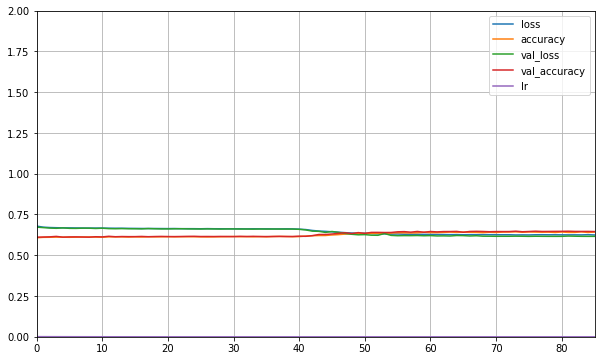

In [147]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(10, 6))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

In [148]:
predictions = model.predict_classes(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.61      0.41      0.49      9564
           1       0.66      0.81      0.73     13470

    accuracy                           0.64     23034
   macro avg       0.63      0.61      0.61     23034
weighted avg       0.64      0.64      0.63     23034



In [89]:
tuner_bo.search(X_train, y_train, epochs=3, validation_split=0.2, class_weight=class_weight,verbose=1)

INFO:tensorflow:Oracle triggered exit


In [90]:
best_model = tuner_bo.get_best_models(num_models=1)[0]
best_model.evaluate(X_test, y_test)

23034/23034 [==============================] - ETA: 1:31 - loss: 5248.5439 - accuracy: 0.500 - ETA: 3s - loss: 4789.1670 - accuracy: 0.5814  - ETA: 3s - loss: 4818.5269 - accuracy: 0.585 - ETA: 2s - loss: 4574.0865 - accuracy: 0.594 - ETA: 3s - loss: 4567.4731 - accuracy: 0.595 - ETA: 3s - loss: 4520.8348 - accuracy: 0.597 - ETA: 3s - loss: 4522.2337 - accuracy: 0.599 - ETA: 3s - loss: 4532.9923 - accuracy: 0.598 - ETA: 3s - loss: 4537.2071 - accuracy: 0.592 - ETA: 3s - loss: 4509.7525 - accuracy: 0.592 - ETA: 2s - loss: 4492.9021 - accuracy: 0.588 - ETA: 2s - loss: 4403.2214 - accuracy: 0.591 - ETA: 2s - loss: 4449.8488 - accuracy: 0.586 - ETA: 2s - loss: 4458.9421 - accuracy: 0.584 - ETA: 1s - loss: 4445.5446 - accuracy: 0.583 - ETA: 1s - loss: 4456.3044 - accuracy: 0.583 - ETA: 1s - loss: 4440.1698 - accuracy: 0.585 - ETA: 1s - loss: 4458.1417 - accuracy: 0.585 - ETA: 1s - loss: 4453.0346 - accuracy: 0.585 - ETA: 1s - loss: 4444.4087 - accuracy: 0.585 - ETA: 1s - loss: 4427.3260 - a

[4486.574475842776, 0.5847877]

In [91]:
# get best hyperameters
tuner_bo.get_best_hyperparameters()[0].values

{'units': 52,
 'num_layers': 2,
 'units_0': 210,
 'drop_rate_0': 0.5,
 'optimizer': 'adam',
 'units_1': 210,
 'units_2': 120,
 'units_3': 180,
 'drop_rate_1': 0.2,
 'drop_rate_2': 0.5,
 'drop_rate_3': 0.2,
 'units_4': 270,
 'units_5': 60,
 'drop_rate_4': 0.5,
 'drop_rate_5': 0.5,
 'dense_activation': 'relu'}

In [152]:
!tensorboard dev upload --logdir my_logs --name "Lending Club" --description "Lending Club"

usage: tensorboard [-h] [--helpfull] {serve,dev} ...
tensorboard: error: unrecognized arguments: --name Lending Club --description Lending Club
